Sat Jun 21st 2025,
Jakob Balkovec

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mtpltlib_patches

import numpy as np
import pandas as pd

from pathlib import Path

import json
import sys

from typing import Tuple

from shapely.geometry import Point, Polygon, box
from shapely.affinity import scale, rotate

# this is to filter "shapely's" warning abt some intersection stuff...
#   I tried debugging it but gave up...if this casues more issues down the road,
#   I'll put more effort into fixing it
import warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in intersection.*")

# ======
sys.path.append(str(Path("../XMLparser").resolve()))

from lesion_parser import LesionXMLParser
from utils import parse_txt_file
# ======


## Configuration

In [2]:
COLOR_MAP = {
    'haemorrhages': ('blue', 0.3),
    'red_small_dots': ('red', 0.3),
    'hard_exudates': ('green', 0.3),
    'soft_exudates': ('orange', 0.3),
    'disc': ('purple', 0.3),
    'irma': ('cyan', 0.3),
    'neovascularisation': ('magenta', 0.3),
    'fundus_area': ('yellow', 0.3)
}

TICK_COLOR_MAP = {
    'haemorrhages': 'white',
    'red_small_dots': 'yellow',
    'hard_exudates': 'black',
    'soft_exudates': 'blue',
    'disc': 'white',
    'irma': 'black',
    'neovascularisation': 'yellow',
    'fundus_area': 'black'
}

PATCH_HALF = 12 # since patches are 25x25
PATCH_SIZE = 25

IMAGE_SIZE = r"1152 x 1500"

PATCH_ROOT = Path("../data/patches")
DATA_ROOT = Path("../data/raw")


## Utility Functions

In [3]:
def draw_grid(image, patch_size, dimensions: Tuple[int, int], color=(255, 0, 0), thickness=1):
    # pre: image is a NumPy array; patch_size is int > 0; dimensions = (height, width)
    # post: returns image copy with red grid overlay
    # desc: overlays a red grid on the image at intervals of patch_size

    # note: dimensions is (height, width)
    # note: color is in BGR format (default is red [255, 0, 0])

    height, width = dimensions

    img = image.copy()

    # vertical
    for x in range(0, width, patch_size):
        cv2.line(img, (x, 0), (x, height), color, thickness)

    # hortizontal
    for y in range(0, height, patch_size):
        cv2.line(img, (0, y), (width, y), color, thickness)
    return img

def plot_image_with_matplotlib_grid(image, patch_size, dimensions: Tuple[int, int], thickness=0.5, grid_size="Not specified", cmap='gray'):
    # pre: image is a NumPy array; patch_size is int > 0
    # post: displays a single plot with a visible grid overlay using matplotlib
    # desc: overlays a red grid using matplotlib on a grayscale or RGB image for visual inspection

    # note: I have to overlay the gird here with matplotlib because OpenCV needs 3 channels to draw lines
    # !important! note: use this ONLY with green channel images
    height, width = dimensions

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    axs[0].imshow(image, cmap=cmap if cmap else None)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(image, cmap=cmap if cmap else None)

    # vertical
    for x in range(0, width, patch_size):
        axs[1].axvline(x=x, color='red', linewidth=thickness)

    # horizontal
    for y in range(0, height, patch_size):
        axs[1].axhline(y=y, color='red', linewidth=thickness)

    axs[1].set_title(f"Grid {grid_size}")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

def generate_clahe_image(image_rgb):
    # pre: image_rgb is a NumPy array in RGB format (e.g., from cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # post: returns a new RGB image with CLAHE applied to the L channel in LAB color space
    # desc: enhances contrast by applying CLAHE to the luminance (L) channel of the image using LAB space

    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def generate_clahe_image_green_channel(grayscale_img, clip_limit=2.0, tile_grid_size=(8, 8)):
    # pre: grayscale_img is a NumPy array in grayscale format
    # post: green chanel of the image is enhanced using CLAHE
    # desc: applies CLAHE to the grayscale image with specified clip limit and tile grid size

    # note: works the same as the one on top of this one. The top one expects 3 channels (RGB),
    #       thus when passing in the green channel image, it throws an error.
    #       this one expects a single channel grayscale image.
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(grayscale_img)

def plot_image_with_grid(image, image_with_grid, grid_size="Not specified", cmap=None):
    # pre: image and image_with_grid are NumPy arrays; grid_size is a string or int
    # post: displays side-by-side plots of original image and image with grid overlay
    # desc: visualizes the effect of applying a grid on an image (as preview)
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].imshow(image, cmap=cmap if cmap else 'gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(image_with_grid, cmap=cmap if cmap else 'gray')
    axs[1].set_title(f'Grid {grid_size}')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

def plot_quadrant_vectors(image, patch_size):
    # pre: image is a NumPy array with a grid already drawn; patch_size is for visual labeling
    # post: displays image with vectors from four corners to center
    # desc: visualizes quadrant origins and arrows pointing to image center

    h, w = image.shape[:2]
    mid_x, mid_y = w // 2, h // 2

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    corners = {
        "TOP LEFT": (0, 0),
        "TOP RIGHT": (w-1, 0),
        "BOT LEFT": (0, h-1),
        "BOT RIGHT": (w-1, h-1)
    }

    for label, (x, y) in corners.items():
        ax.annotate("", xy=(mid_x, mid_y), xytext=(x, y),
                    arrowprops=dict(facecolor='yellow', arrowstyle='->', lw=2))
        ax.text(x, y, f"{label}\n({x}, {y})", color='white', fontsize=10,
                bbox=dict(facecolor='black', alpha=0.6))

    ax.plot(mid_x, mid_y, 'ro', markersize=6)
    ax.text(mid_x + 10, mid_y, f"Center\n({mid_x}, {mid_y})", color='red', fontsize=9)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Vectors to Center")
    plt.tight_layout()
    plt.show()

def jsonize(patch_dict_list, indent=4, summarize_patch=True):
    # pre: patch_dict_list is a list of dictionaries containing patch data
    # post: returns a JSON-formatted string representation of the patch data
    # desc: Converts a list of patch dictionaries into a JSON-serializable string, replacing NumPy arrays with lists.

    # note: if summarize_patch is True ( = debugging), the np arrays are summarized as their shape instead of being fully expanded.

    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist() if not summarize_patch else f"<array shape={obj.shape}>"
        elif isinstance(obj, tuple):
            return list(obj)
        return obj

    clean_list = []
    for patch in patch_dict_list:
        clean_patch = {k: convert(v) if k != "coordinates" else {kk: list(vv) for kk, vv in v.items()}
                       for k, v in patch.items()}
        clean_list.append(clean_patch)

    return json.dumps(clean_list, indent=indent)

def plot_patch_with_grid(patch, color=(255, 0, 0)):
    # pre: patch is a NumPy array representing an image; color is a tuple (B, G, R)
    # post: displays the patch with a 1x1 grid overlay
    # desc: displays a patch with a 1x1 grid overlay using OpenCV and matplotlib

    patch_vis = patch.copy()

    h, w = patch_vis.shape[:2]

    cv2.line(patch_vis, (0, 0), (w - 1, 0), color, 1)          # top
    cv2.line(patch_vis, (0, 0), (0, h - 1), color, 1)          # left
    cv2.line(patch_vis, (w - 1, 0), (w - 1, h - 1), color, 1)  # right
    cv2.line(patch_vis, (0, h - 1), (w - 1, h - 1), color, 1)  # bottom

    plt.figure(figsize=(2, 2))
    plt.imshow(patch_vis)
    plt.title("Patch with 1x1 Grid")
    plt.axis('off')
    plt.show()

def plot_patch_with_matplotlib_grid(patch, color='red', linewidth=0.5, cmap=None):
    # pre: patch is a NumPy array (grayscale or RGB); color is grid line color
    # post: displays the patch with a 1x1 grid overlay using matplotlib
    # desc: overlays a border (1x1 grid) on a patch using matplotlib lines

    h, w = patch.shape[:2]

    plt.figure(figsize=(2, 2))
    plt.imshow(patch, cmap=cmap if cmap else None)

    plt.axhline(y=0, color=color, linewidth=linewidth)        # top
    plt.axhline(y=h - 1, color=color, linewidth=linewidth)    # bottom
    plt.axvline(x=0, color=color, linewidth=linewidth)        # left
    plt.axvline(x=w - 1, color=color, linewidth=linewidth)    # right

    plt.title("Patch with 1x1 Grid")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_patch_with_matplotlib_grid(df, random_index, cmap=None):
    # note: wrapper function
    # see: plot_image_with_matplotlib_grid(...)
    patch = df["patch"][random_index]
    h, w = patch.shape[0], patch.shape[1]

    plot_image_with_matplotlib_grid(patch, patch_size=1, dimensions=(h, w), thickness=0.3, grid_size="1x1x", cmap=cmap)

def plot_patch_block(patch_list, n_rows, n_cols, cmap='gray', title="Not Specified"):
    # pre: patch_list is a list of patches (2D or 3D); all patches must be same shape
    # post: displays a dense patch grid using matplotlib
    # desc: arranges and shows patches in a tight grid (e.g., 50x50) with minimal gaps

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 0.3, n_rows * 0.3))

    fig.suptitle(title, fontsize=12, y=1.02)

    for i in range(n_rows * n_cols):
        row, col = divmod(i, n_cols)
        ax = axs[row, col] if n_rows > 1 else axs[col]
        patch = patch_list[i]
        ax.imshow(patch, cmap=cmap if len(patch.shape) == 2 else None)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.tight_layout(pad=0.1)
    plt.show()

def is_lesion_in_patch(patch_coords, lesion_x, lesion_y):
    # pre: patch_coords is a dictionary with 'top_left' and 'bottom_right' keys, lesion_x and lesion_y are coordinates
    # post: returns True if lesion is within the patch coordinates, False otherwise
    # desc: checks if lesion coordinates are within the specified patch coordinates

    x1, y1 = patch_coords['top_left']
    x2, y2 = patch_coords['bottom_right']
    return x1 <= lesion_x <= x2 and y1 <= lesion_y <= y2

def deduplicate_labels(label):
    # pre: label can be a single label or a list/tuple of labels
    # post: returns a single label or a tuple of unique labels
    # desc: ensures that labels are unique and sorted, especially for multiple lesion types

    # note: this is lazy and only here to decrease the workload later on.

    def clean(x):
        return str(x).strip().capitalize()

    if isinstance(label, (list, tuple)):
        cleaned = [clean(l) for l in label]
        return tuple(sorted(set(cleaned))) if len(set(cleaned)) > 1 else clean(cleaned[0])
    elif isinstance(label, str):
        return clean(label)
    return None

def label_patches_from_lesions(patches_df, lesions_df):
    # pre: patches_df is a DataFrame with 'coordinates' column containing patch coordinates,
    #      lesions_df is a DataFrame with 'x', 'y', and 'type' columns for lesion coordinates and types
    # post: returns a DataFrame with updated labels for each patch based on lesion overlaps
    # desc: labels each patch based on whether it contains lesions, and flags overlaps

    updated_patches = []

    for idx, patch in patches_df.iterrows():
        matches = lesions_df[
            lesions_df.apply(
                lambda row: is_lesion_in_patch(patch['coordinates'], row['x'], row['y']),
                axis=1
            )
        ]

        if matches.empty:
            label = "healthy"
            overlap = False
        else:
            raw_labels = matches['type'].tolist()
            label = deduplicate_labels(raw_labels)
            overlap = len(set(raw_labels)) > 1

        patch['lesion_id'] = idx
        patch['label'] = label
        patch['overlap_flag'] = overlap
        updated_patches.append(patch)

    return pd.DataFrame(updated_patches)

def plot_patch_with_lesions(patch_row, lesions_df, color='red'):
    # pre: patch_row is a row from the patch DataFrame; lesions_df is the full XML DataFrame
    # post: plots the patch with a rectangle and any included lesion markers
    # desc: overlays the patch region and marks lesions within it

    coords = patch_row['coordinates']
    patch_img = patch_row['patch']
    patch_center = patch_row['center']
    patch_label = patch_row['label']
    patch_no = patch_row['patch_no']

    x1, y1 = coords['top_left']
    x2, y2 = coords['bottom_right']

    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
    ax.imshow(patch_img if len(patch_img.shape) == 3 else patch_img, cmap='gray' if len(patch_img.shape) == 2 else None)

    ax.set_title(f"Patch #{patch_no} | Label: {patch_label}", fontsize=8)

    text_str = (
        f"Coords: TL=({x1},{y1}) BR=({x2},{y2})\n"
        f"Center: {patch_center}"
    )

    fig.text(0.5, -0.05, text_str, ha='center', va='top', fontsize=7)


    ax.axis('off')

    cx = patch_center[0] - x1
    cy = patch_center[1] - y1

    matching_lesions = lesions_df[
        lesions_df.apply(lambda row: x1 <= row['x'] <= x2 and y1 <= row['y'] <= y2, axis=1)
    ]

    for _, lesion in matching_lesions.iterrows():
        lx = int(lesion['x'] - x1)
        ly = int(lesion['y'] - y1)
        ax.plot(lx, ly, marker='x', color='yellow', markersize=2)
        ax.text(lx + 1, ly + 1, lesion['type'], fontsize=5, color='yellow')

    plt.tight_layout()
    plt.show()

def visualize_lesion_regions_subplots(duplicates_df, lesions_df, plotting_relabeled=False, n_cols=4):
    # pre: non-empty duplicates_df and lesions_df
    # post: renders one figure with subplots showing lesion regions per patch
    # desc: highlights lesion areas with color-coded overlays and ticks

    n = len(duplicates_df)
    n_rows = (n + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.5, n_rows * 3.5), dpi=150)
    axs = axs.flatten()

    for i, (_, patch) in enumerate(duplicates_df.iterrows()):
        coords = patch['coordinates']
        patch_img = patch['patch']
        x1, y1 = coords['top_left']
        x2, y2 = coords['bottom_right']
        ax = axs[i]

        ax.imshow(patch_img if len(patch_img.shape) == 3 else patch_img, cmap='gray' if len(patch_img.shape) == 2 else None)

        label_text = patch.get('relabel_label', patch.get('label', ''))
        if isinstance(label_text, (list, tuple)):
            label_text = ", ".join(map(str, label_text))
        if pd.isna(label_text):
            label_text = ""

        ax.set_title(f"#{patch['patch_no']} | {label_text}", fontsize=8)

        local_lesions = lesions_df[
            lesions_df.apply(lambda row: x1 <= row['x'] <= x2 and y1 <= row['y'] <= y2, axis=1)
        ]

        for _, lesion in local_lesions.iterrows():
            lx, ly = lesion['x'] - x1, lesion['y'] - y1
            radius = lesion['radius']
            ltype = str(lesion['type']).strip().lower()
            rtype = lesion["region_type"]
            polygon_points = lesion["polygon_points"]

            tick_color = TICK_COLOR_MAP.get(ltype, 'white')
            circle_color = COLOR_MAP.get(ltype, ('gray', 0.3))[0]

            ax.plot(lx, ly, marker='x', color=tick_color, markersize=3.5, linewidth=0.6)

            label_text = rtype.replace("region", "").capitalize()

            if rtype == "circleregion":
                circ = mtpltlib_patches.Circle((lx, ly), radius=radius, linewidth=0.5,
                                    edgecolor=circle_color, facecolor=circle_color, alpha=0.3)
                ax.add_patch(circ)

            elif rtype == "polygonregion":
                # need global to local transformation
                local_poly_points = [(px - x1, py - y1) for (px, py) in polygon_points]

                poly = mtpltlib_patches.Polygon(local_poly_points, closed=True, linewidth=0.5,
                    edgecolor=circle_color, facecolor=circle_color, alpha=0.3)

                ax.add_patch(poly)

            elif rtype == "ellipseregion":
                ellipse = mtpltlib_patches.Ellipse((lx, ly), width=2*lesion["radius_x"], height=2*lesion["radius_y"],
                  angle=lesion["angle"], linewidth=0.5,
                  edgecolor=circle_color, facecolor=circle_color, alpha=0.3)

                ax.add_patch(ellipse)

        ax.axis('off')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

def get_lesion_geometry(lesion):
    # pre: lesion has to be a valid entry in the dataframe
    # post: a "shapely" shape wrt to "region_type" in the df
    # desc: converts it to a "shapely" shape

    x, y = lesion['x'], lesion['y']
    rtype = lesion['region_type']

    if rtype == 'circleregion':
        return Point(x, y).buffer(lesion['radius'])

    elif rtype == 'ellipseregion':
        base = Point(x, y).buffer(1)
        scaled = scale(base, lesion['radius_x'], lesion['radius_y'])
        return rotate(scaled, lesion['angle'], origin=(x, y), use_radians=False)

    elif rtype == 'polygonregion':
        return Polygon(lesion['polygon_points'])

    return None

def get_dominant_lesion_by_area(patch_coords, local_lesions):
    # pre: 'patch_coords' contains 'top_left' and 'bottom_right' tuples. 'local_lesions' is a Pandas DataFrame with 'type' and geometric data.
    # post: returns a tuple (dominant_lesion_type, area_map). 'dominant_lesion_type' is 'healthy', a string, or a tuple of strings.
    #       'area_map' maps lesion types to their intersected areas.
    # desc: calculates the dominant lesion type within a specified patch based on the largest intersected area.

    x1, y1 = patch_coords['top_left']
    x2, y2 = patch_coords['bottom_right']
    patch_box = box(x1, y1, x2, y2)

    area_map = {}
    lesion_by_type = {}

    for _, lesion in local_lesions.iterrows():
        shape = get_lesion_geometry(lesion)
        if shape is None or not (patch_box.is_valid and shape.is_valid):
            continue

        intersection = patch_box.intersection(shape)
        if not intersection.is_empty:
            ltype = str(lesion['type']).strip().lower()
            area_map[ltype] = area_map.get(ltype, 0) + intersection.area
            lesion_by_type.setdefault(ltype, []).append(lesion.to_dict())

    if not area_map:
        return "healthy", {}, []

    max_area = max(area_map.values())
    dominant_lesions = [lt for lt, area in area_map.items() if area == max_area]
    final_label = dominant_lesions[0] if len(dominant_lesions) == 1 else tuple(dominant_lesions)

    # Keep only shapes for the dominant lesion(s)
    if isinstance(final_label, str):
        filtered_lesions = [lesion for lesion in lesion_by_type.get(final_label, [])
                            if str(lesion['type']).strip().lower() == final_label]
        filtered_area_map = {final_label: area_map[final_label]}
    else:
        filtered_lesions = []
        filtered_area_map = {}
        for label in final_label:
            filtered_lesions.extend([
                lesion for lesion in lesion_by_type.get(label, [])
                if str(lesion['type']).strip().lower() == label
            ])
            filtered_area_map[label] = area_map[label]

    return final_label, filtered_area_map, filtered_lesions

def relabel_patches_by_area(patch_df, lesion_df):
    # pre: 'patch_df' contains 'coordinates' with 'top_left' and 'bottom_right'. 'lesion_df' contains 'x' and 'y' coordinates for lesions.
    # post: returns a new DataFrame 'relabeled_df' with 'relabel' and 'area_map' columns added.
    # desc: relabels each patch in 'patch_df' based on the dominant lesion type by area from 'lesion_df' within its boundaries.

    relabeled_df = patch_df.copy()
    relabels = []
    areas = []
    lesion_shapes = []

    for _, patch in relabeled_df.iterrows():
        coords = patch['coordinates']
        local_lesions = lesion_df[
            lesion_df.apply(
                lambda row: coords['top_left'][0] <= row['x'] <= coords['bottom_right'][0] and
                            coords['top_left'][1] <= row['y'] <= coords['bottom_right'][1],
                axis=1
            )
        ]

        label, area_map, lesion_list = get_dominant_lesion_by_area(coords, local_lesions)
        relabels.append(label)
        areas.append(area_map)
        lesion_shapes.append(lesion_list)

    relabeled_df['relabel_label'] = relabels
    relabeled_df['area_map'] = areas
    relabeled_df['relabel'] = lesion_shapes
    return relabeled_df



## Parsing the Data

In [4]:
parsed_text_input = parse_txt_file("../data/raw/ddb1_v02_01_test_plain.txt")
single_entry = parsed_text_input[0]

parser = LesionXMLParser(xml_input=[single_entry], root_dir=DATA_ROOT)
lesions = parser.parse()

lesions_pd_frame = parser.to_format("pandas")


## Sanity Checks

In [5]:
print(json.dumps(single_entry, indent=2))
print(lesions_pd_frame.head())

lesions_pd_frame[lesions_pd_frame["region_type"] != "circleregion"]


{
  "image": "images/diaretdb1_image002.png",
  "xmls": [
    "groundtruth/diaretdb1_image002_01_plain.xml",
    "groundtruth/diaretdb1_image002_02_plain.xml",
    "groundtruth/diaretdb1_image002_03_plain.xml",
    "groundtruth/diaretdb1_image002_04_plain.xml"
  ]
}
                      image_path            image_id  \
0  images/diaretdb1_image002.png  diaretdb1_image002   
1  images/diaretdb1_image002.png  diaretdb1_image002   
2  images/diaretdb1_image002.png  diaretdb1_image002   
3  images/diaretdb1_image002.png  diaretdb1_image002   
4  images/diaretdb1_image002.png  diaretdb1_image002   

                          xml_file          type  lesion_id       x      y  \
0  diaretdb1_image002_01_plain.xml  Haemorrhages          0   570.0  805.0   
1  diaretdb1_image002_01_plain.xml  Haemorrhages          1   669.0  685.0   
2  diaretdb1_image002_01_plain.xml  Haemorrhages          2   811.0  733.0   
3  diaretdb1_image002_01_plain.xml  Haemorrhages          3   895.0  700.0   
4  dia

image_path            image_id  \
24  images/diaretdb1_image002.png  diaretdb1_image002   
31  images/diaretdb1_image002.png  diaretdb1_image002   
32  images/diaretdb1_image002.png  diaretdb1_image002   
33  images/diaretdb1_image002.png  diaretdb1_image002   
36  images/diaretdb1_image002.png  diaretdb1_image002   
40  images/diaretdb1_image002.png  diaretdb1_image002   
44  images/diaretdb1_image002.png  diaretdb1_image002   
45  images/diaretdb1_image002.png  diaretdb1_image002   
53  images/diaretdb1_image002.png  diaretdb1_image002   
54  images/diaretdb1_image002.png  diaretdb1_image002   
55  images/diaretdb1_image002.png  diaretdb1_image002   
56  images/diaretdb1_image002.png  diaretdb1_image002   

                           xml_file            type  lesion_id       x      y  \
24  diaretdb1_image002_03_plain.xml  Red_small_dots         24   919.0  582.0   
31  diaretdb1_image002_03_plain.xml   Hard_exudates         31   696.0  586.0   
32  diaretdb1_image002_03_plain.xml   Hard_exudates         32   695.0  628.0   
33  diaretdb1_image002_03_plain.xml   Hard_exudates         33   595.0  509.0   
36  diaretdb1_image002_03_plain.xml   Hard_exudates         36   549.0  534.0   
40  diaretdb1_image002_04_plain.xml   Hard_exudates         40   666.0  559.0   
44  diaretdb1_image002_04_plain.xml    Haemorrhages         44  1171.0  515.0   
45  diaretdb1_image002_04_plain.xml    Haemorrhages         45  1051.0  715.0   
53  diaretdb1_image002_04_plain.xml    Haemorrhages         53   837.0  748.0   
54  diaretdb1_image002_04_plain.xml    Haemorrhages         54   662.0  679.0   
55  diaretdb1_image002_04_plain.xml    Haemorrhages         55   893.0  698.0   
56  diaretdb1_image002_04_plain.xml    Haemorrhages         56   568.0  802.0   

        radius  radius_x  radius_y  angle  \
24   21.000000      25.0      17.0   92.0   
31    9.500000      11.0       8.0  175.0   
32   10.000000      12.0       8.0  138.0   
33   24.000000      27.0      21.0  124.0   
36   26.000000      30.0      22.0  120.0   
40  155.595630       NaN       NaN    NaN   
44   22.472205       NaN       NaN    NaN   
45   22.203603       NaN       NaN    NaN   
53   21.633308       NaN       NaN    NaN   
54   16.031220       NaN       NaN    NaN   
55   20.518285       NaN       NaN    NaN   
56   22.000000       NaN       NaN    NaN   

                                       polygon_points    region_type  
24                                                 []  ellipseregion  
31                                                 []  ellipseregion  
32                                                 []  ellipseregion  
33                                                 []  ellipseregion  
36                                                 []  ellipseregion  
40  [(575.0, 472.0), (552.0, 484.0), (519.0, 508.0...  polygonregion  
44  [(1172.0, 502.0), (1163.0, 510.0), (1156.0, 52...  polygonregion  
45  [(1049.0, 700.0), (1037.0, 709.0), (1037.0, 72...  polygonregion  
53  [(848.0, 737.0), (837.0, 730.0), (825.0, 737.0...  polygonregion  
54  [(658.0, 667.0), (652.0, 676.0), (648.0, 686.0...  polygonregion  
55  [(904.0, 697.0), (901.0, 686.0), (892.0, 681.0...  polygonregion  
56  [(577.0, 791.0), (567.0, 787.0), (554.0, 787.0...  polygonregion

## Load the Images

In [6]:
image_path = DATA_ROOT / single_entry["image"]
image = cv2.imread(str(image_path))

# rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# green channel
image_green_channel = image[:, :, 1]

# CLAHE (rgb image)
image_rgb_clahe = generate_clahe_image(image_rgb)

# green channel with CLAHE
image_green_channel_clahe = generate_clahe_image_green_channel(image_green_channel)

# pack values
height, width = image_rgb.shape[:2]
dimensions = (height, width)


## Patches

In [7]:
print(f"\n{height} x {width} = {height * width} pixels")

print(f"\t[25 x 25] If we use {PATCH_SIZE}x{PATCH_SIZE} patches, we get {height // PATCH_SIZE} x {width // PATCH_SIZE} = {(height // PATCH_SIZE) * (width // PATCH_SIZE)} patches per image")
print(f"\t[50 x 50] If we use {PATCH_SIZE * 2}x{PATCH_SIZE * 2} patches, we get {height // (PATCH_SIZE * 2)} x {width // (PATCH_SIZE * 2)} = {(height // (PATCH_SIZE * 2)) * (width // (PATCH_SIZE  * 2))} patches per image\n")



1152 x 1500 = 1728000 pixels
	[25 x 25] If we use 25x25 patches, we get 46 x 60 = 2760 patches per image
	[50 x 50] If we use 50x50 patches, we get 23 x 30 = 690 patches per image



## Plotting the Image with a Grid

### RGB `(50 x 50)`

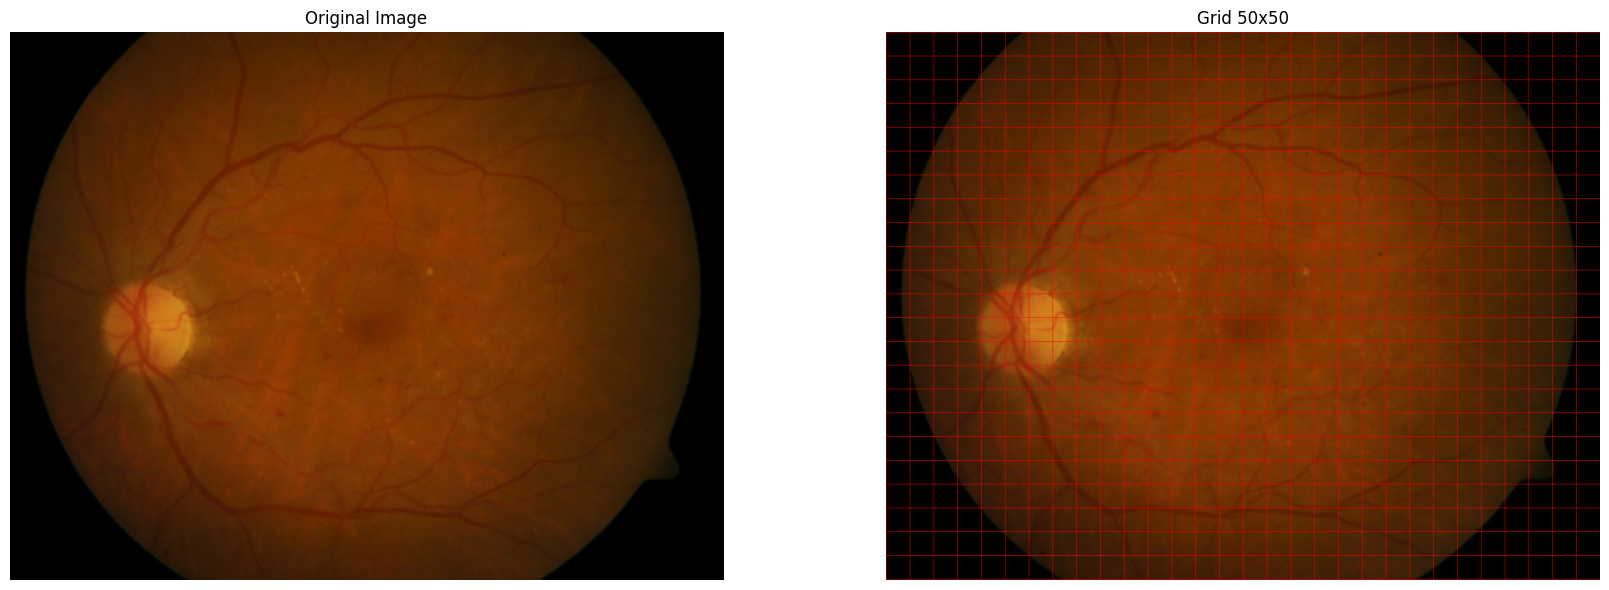

In [8]:
image_grid_50 = draw_grid(image_rgb, 50, dimensions)
plot_image_with_grid(image_rgb, image_grid_50, grid_size="50x50")


This is just to visualize/simulate the number of patches extracted from the image. I overlaid a grid over all types of images, just to see the comparison. I got the "vibe that we call roll with both CLAHE and green channel from the meeting.

### Green Channel `(50 x 50)`

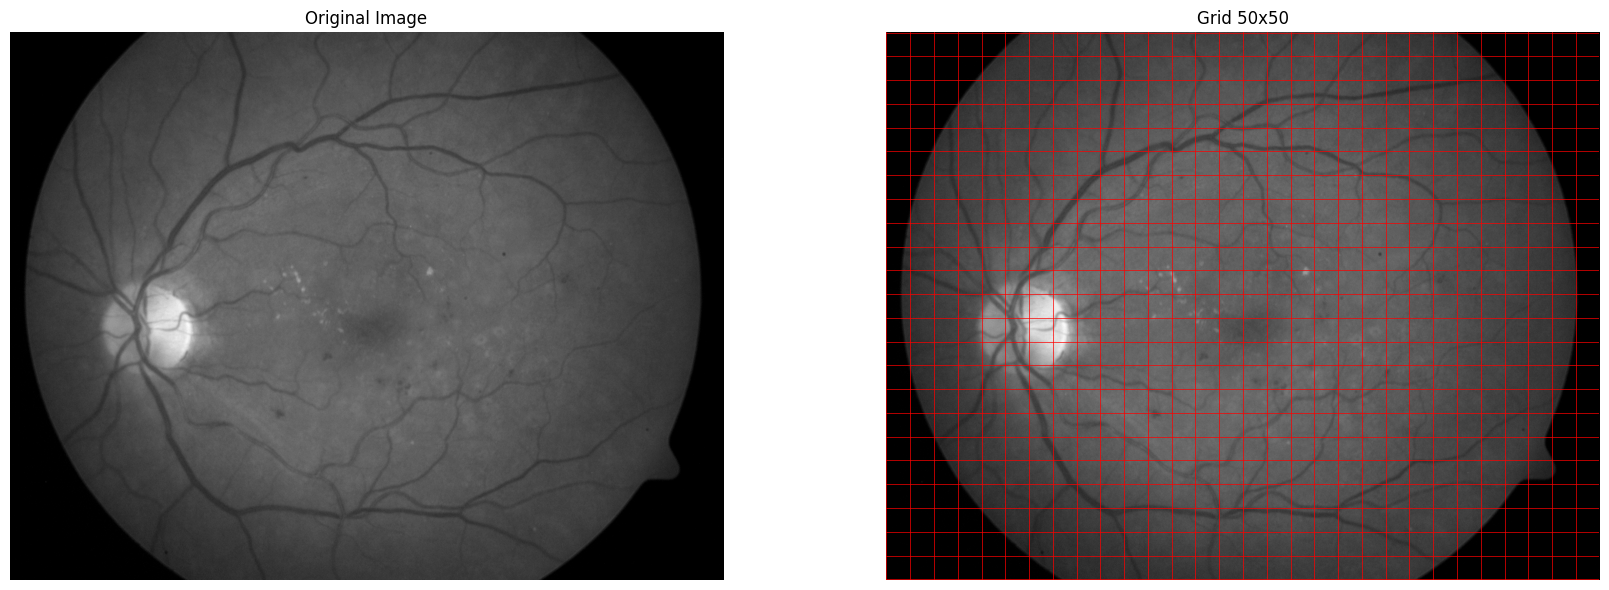

In [9]:
plot_image_with_matplotlib_grid(image_green_channel, 50, dimensions, grid_size="50x50", cmap='gray')


This is just to visualize/simulate the number of patches extracted from the image. I overlaid a grid over all types of images, just to see the comparison. I got the "vibe that we call roll with both CLAHE and green channel from the meeting.

### CLAHE `(50 x 50)`

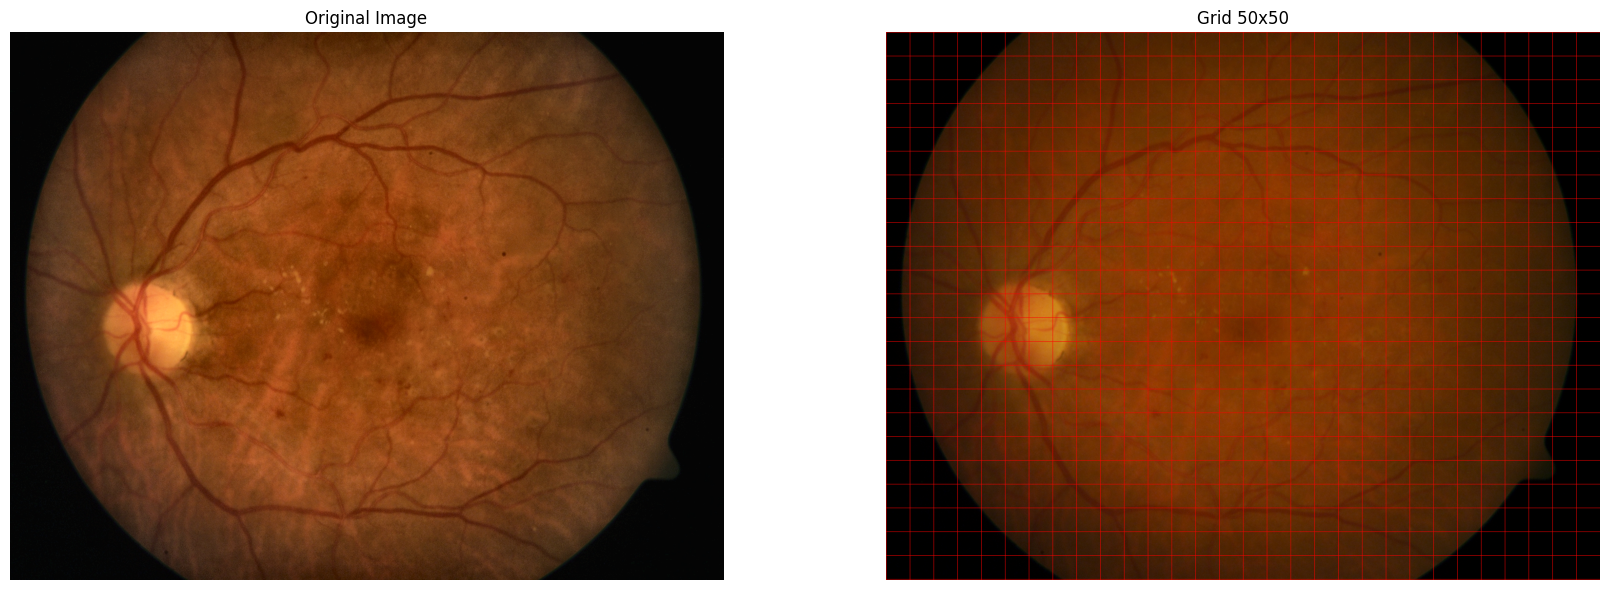

In [10]:
image_grid_50 = draw_grid(image_rgb, 50, dimensions)
plot_image_with_grid(image_rgb_clahe, image_grid_50, grid_size="50x50")


This is just to visualize/simulate the number of patches extracted from the image. I overlaid a grid over all types of images, just to see the comparison. I got the "vibe that we call roll with both CLAHE and green channel from the meeting.

### Green Chanell + CLAHE `(50 x 50)`

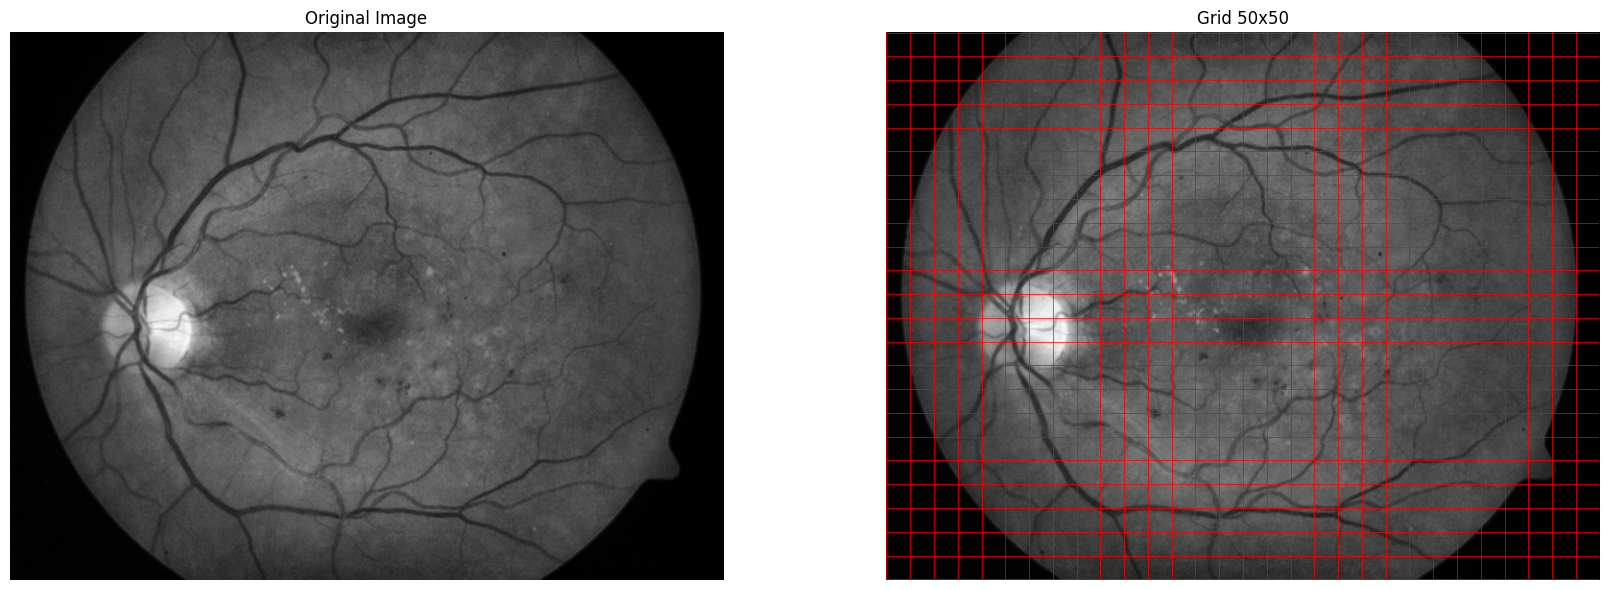

In [11]:
plot_image_with_matplotlib_grid(image_green_channel_clahe, 50, dimensions, grid_size="50x50", cmap='gray')


This is just to visualize/simulate the number of patches extracted from the image. I overlaid a grid over all types of images, just to see the comparison. I got the "vibe that we call roll with both CLAHE and green channel from the meeting.

### RGB `(25 x 25)`

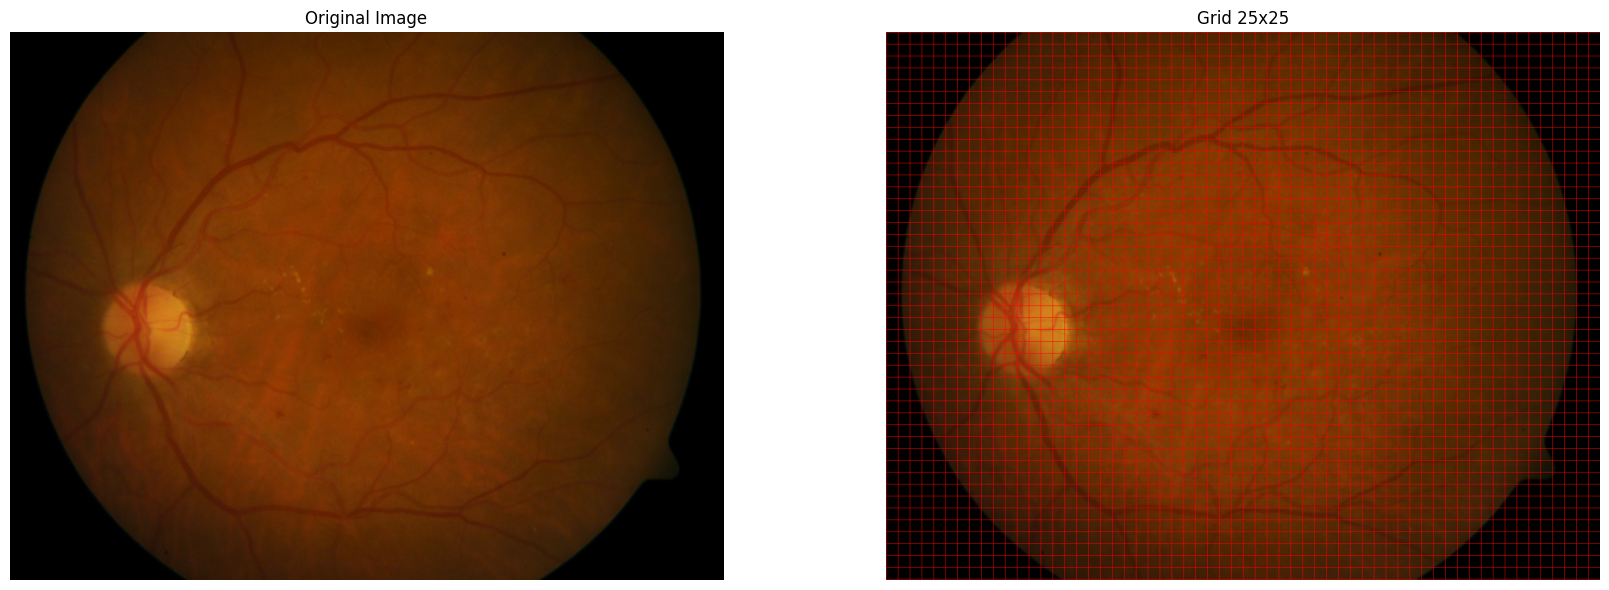

In [12]:
image_grid_50 = draw_grid(image_rgb, 25, dimensions)
plot_image_with_grid(image_rgb, image_grid_50, grid_size="25x25")


This is just to visualize/simulate the number of patches extracted from the image. I overlaid a grid over all types of images, just to see the comparison. I got the "vibe that we call roll with both CLAHE and green channel from the meeting.

### Green Channel `(25 x 25)`

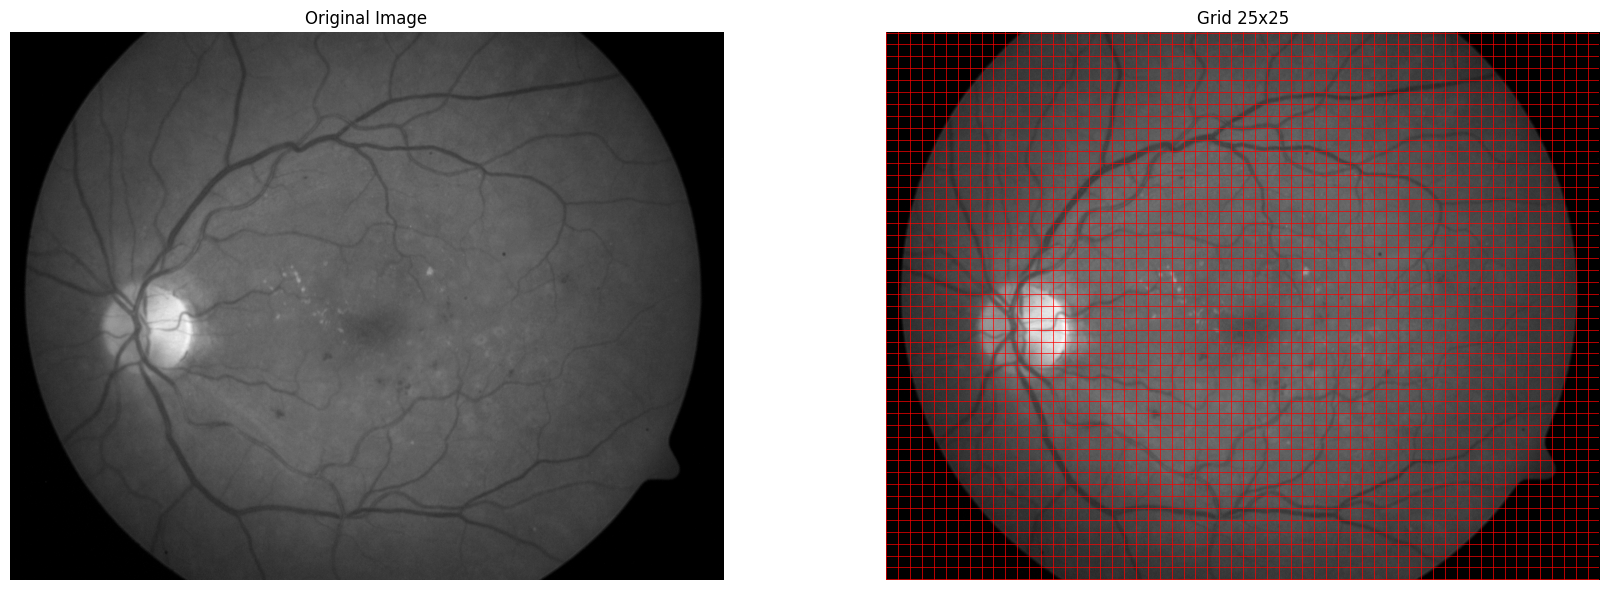

In [13]:
plot_image_with_matplotlib_grid(image_green_channel, 25, dimensions, grid_size="25x25", cmap='gray')


This is just to visualize/simulate the number of patches extracted from the image. I overlaid a grid over all types of images, just to see the comparison. I got the "vibe that we call roll with both CLAHE and green channel from the meeting.

### CLAHE `(25 x 25)`

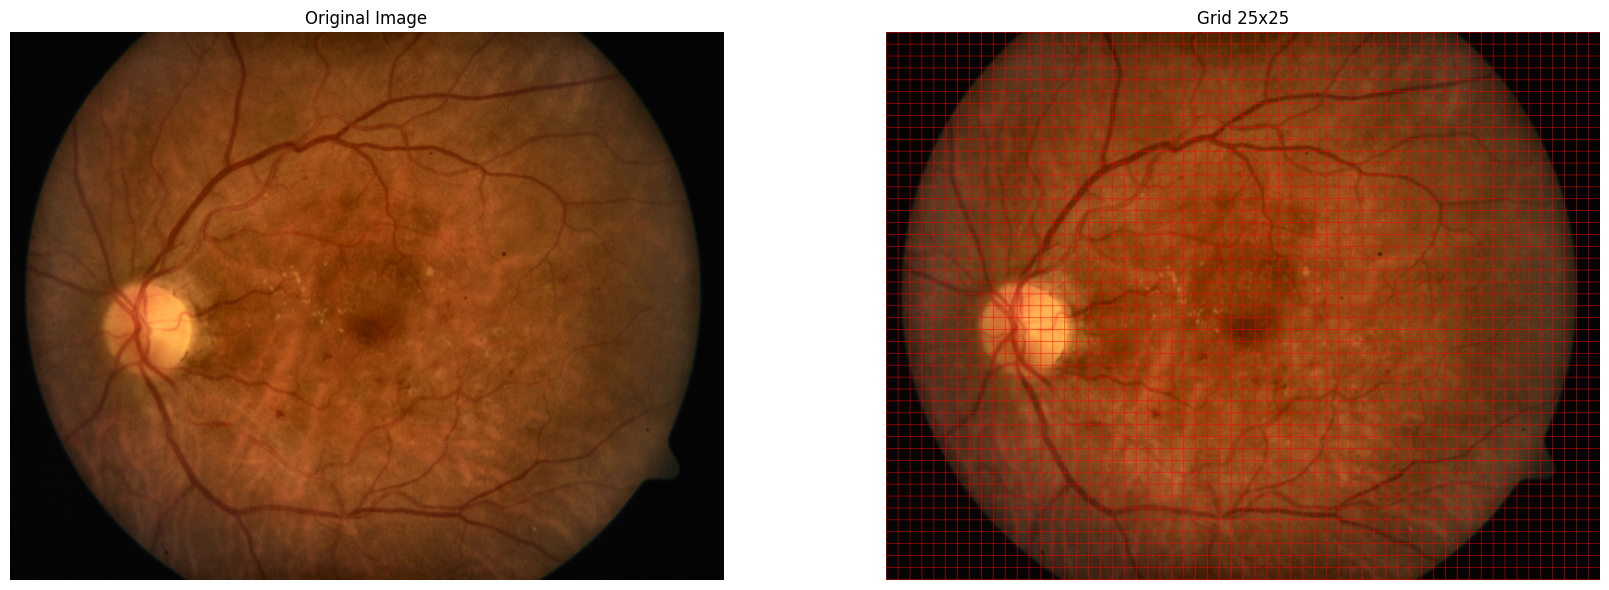

In [14]:
image_grid_50 = draw_grid(image_rgb_clahe, 25, dimensions)
plot_image_with_grid(image_rgb_clahe, image_grid_50, grid_size="25x25")


This is just to visualize/simulate the number of patches extracted from the image. I overlaid a grid over all types of images, just to see the comparison. I got the "vibe that we call roll with both CLAHE and green channel from the meeting.

### Green Channel + CLAHE `(25 x 25)`

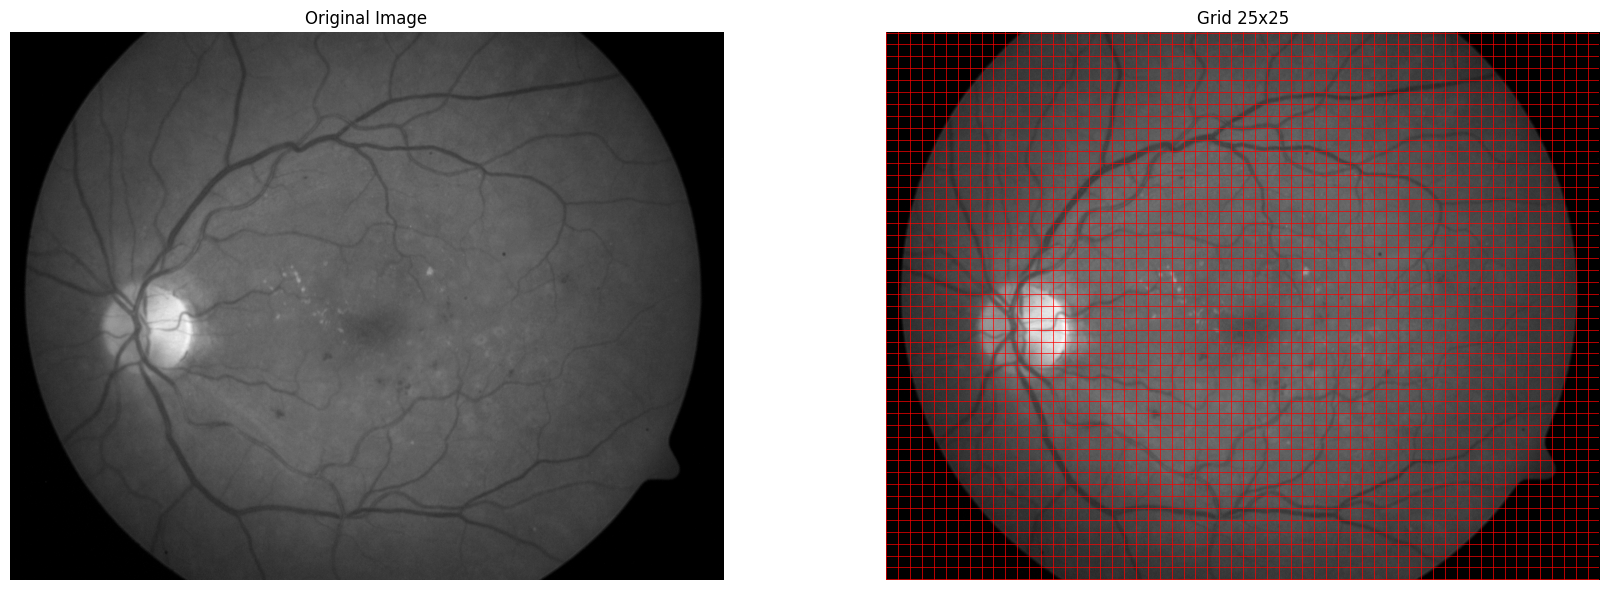

In [15]:
plot_image_with_matplotlib_grid(image_green_channel, 25, dimensions, grid_size="25x25", cmap='gray')


This is just to visualize/simulate the number of patches extracted from the image. I overlaid a grid over all types of images, just to see the comparison. I got the "vibe that we call roll with both CLAHE and green channel from the meeting.

## Sanity Checks

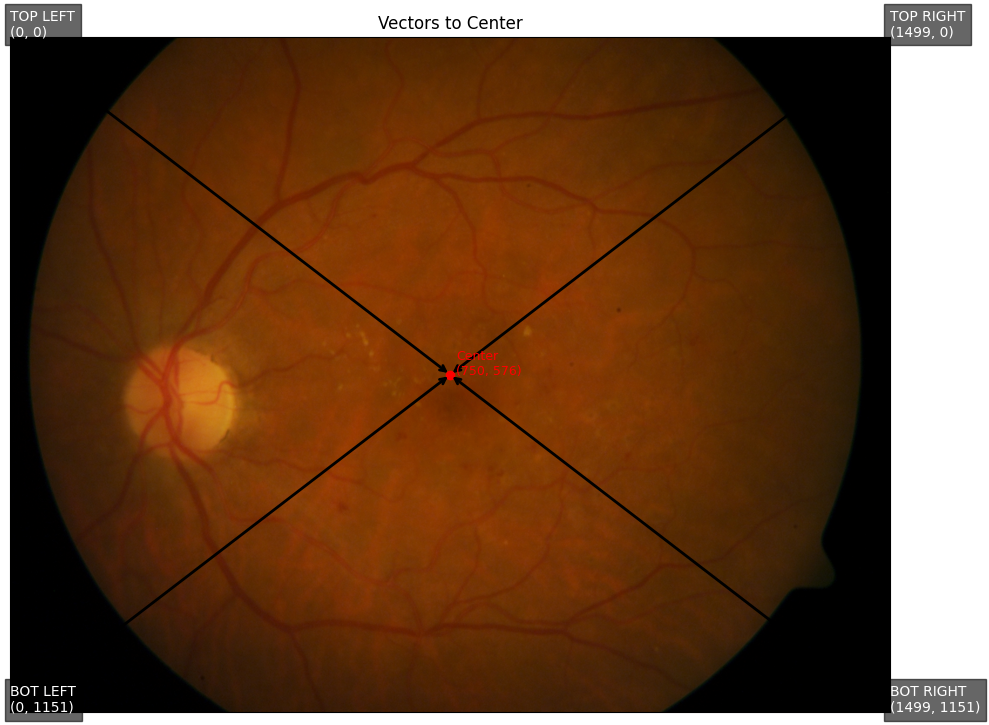

In [16]:
plot_quadrant_vectors(image_rgb, 500)


I'm doing this here to avoid errors down the road. The coordinates start from the top left corner `(min, min) | (0,0)` and end at the bottom right corner `(max, max) | (width, height)`. Better safe than sorry.

## Patch Extraction

My initial idea is to extract a patch alongside some other stuff (call it metadata). What I'm thinking is, extract the patch itself (img), and all 4 corners of the patch (coordinates) which would then define a `25 x 25` square. 

To be more specific, something like this:

```python
{
    "source_img": source_img_name,   # extract
    "patch": <img>,                  # image array
    "center": (x, y),                # useful for proximity based matching
    "coordinates": {                 # self-explanatory...
        "top_left": (x1, y1),         
        "top_right": (x2, y1),        
        "bottom_left": (x1, y2),      
        "bottom_right": (x2, y2)      
    },                                
    "label": "label",                # initially none, added later
    overlap_flag: false,             # [EXPERIMENTAL] initially false, added later
}
```
Some of this stuff is going to be `null`/`None` at first, but it's not that expensive to hold an extra column in the data frame. If we don't need it, we can always drop it later.

Later we can use this data and cross reference it with the XML data to label the patches. My approach (as of right now) is to use the 4 corners of the patch to define the square. If the lesion is within that region, we can label it as such. If not, we can label it as "healthy" or "no lesion"...If there is overlap I'll toggle the overlap flag to `true`, add 2 or more entries to label (making it a tuple), and we can handle it later.


In [17]:
def extract_patches_with_metadata(image, patch_size, source_img_name, skip_non_full_patches=False):
    # pre: image is a NumPy array; patch_size is int > 0; source_img_name is str
    # post: returns a list of dicts, each describing a patch and its metadata
    # desc: slices image into non-overlapping patches and attaches spatial/traceability info

    # note: if skip_non_full_patches is True, it skips patches that do not fit the full patch size
    #  -> mostly patches along the edges that are something like 25 x 20
    #       -> I say mostly because I haven't tested this thoroughly
    #          with all possible patch sizes, just noticed 4 cases

    height, width = image.shape[:2]
    patches = []

    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            x1, y1 = x, y
            x2, y2 = x + patch_size, y + patch_size

            if skip_non_full_patches and (x2 > width or y2 > height):
                continue  # skip incomplete patch

            x2 = min(x2, width)
            y2 = min(y2, height)

            patch = image[y1:y2, x1:x2]
            center = ((x1 + x2) // 2, (y1 + y2) // 2)

            patch_info = {
                "source_img": source_img_name,
                "patch_no": len(patches) + 1,
                "patch": patch,
                "center": center,
                "coordinates": {
                    "top_left": (x1, y1),
                    "top_right": (x2 - 1, y1),
                    "bottom_left": (x1, y2 - 1),
                    "bottom_right": (x2 - 1, y2 - 1)
                },
                "label": None,
                "overlap_flag": False
            }

            patches.append(patch_info)

    return patches



In [18]:
patches = extract_patches_with_metadata(image_rgb, patch_size=25, source_img_name="diaretdb1_image002.png")
full_patches = extract_patches_with_metadata(image_rgb, patch_size=25, source_img_name="diaretdb1_image002.png", skip_non_full_patches=True)

print(f"[patches]:      Extracted {len(patches)} patches from the image.")
print(f"[full_pathces]: Extracted {len(full_patches)} patches from the image.")


[patches]:      Extracted 2820 patches from the image.
[full_pathces]: Extracted 2760 patches from the image.


## Randomly Selected Patch Data

In [19]:
random_index = np.random.randint(0, len(patches))
print(jsonize([patches[random_index]], indent=4))


[
    {
        "source_img": "diaretdb1_image002.png",
        "patch_no": 2119,
        "patch": "<array shape=(25, 25, 3)>",
        "center": [
            462,
            887
        ],
        "coordinates": {
            "top_left": [
                450,
                875
            ],
            "top_right": [
                474,
                875
            ],
            "bottom_left": [
                450,
                899
            ],
            "bottom_right": [
                474,
                899
            ]
        },
        "label": null,
        "overlap_flag": false
    }
]


## Patch Data Frames

I've decided to work only with full patches from this point on. I don't really see the point of working with partial patches, since they are completely black (around the edges) + we can always extract them later if needed...

In [20]:
# rgb | extrcated earlier
rgb_patches = pd.DataFrame(full_patches)

# CLAHE
full_patches_clahe = extract_patches_with_metadata(image_rgb_clahe, patch_size=25, source_img_name="diaretdb1_image002.png", skip_non_full_patches=True)
clahe_patches = pd.DataFrame(full_patches_clahe)

# green channel
full_patches_green_channel = extract_patches_with_metadata(image_green_channel, patch_size=25, source_img_name="diaretdb1_image002.png", skip_non_full_patches=True)
green_channel_patches = pd.DataFrame(full_patches_green_channel)

# green channel + CLAHE
full_patches_green_channel_clahe = extract_patches_with_metadata(image_green_channel_clahe, patch_size=25, source_img_name="diaretdb1_image002.png", skip_non_full_patches=True)
green_channel_clahe_patches = pd.DataFrame(full_patches_green_channel_clahe)


## Sanity Checks

In [21]:
rgb_patches.head(n=3)


source_img  patch_no  \
0  diaretdb1_image002.png         1   
1  diaretdb1_image002.png         2   
2  diaretdb1_image002.png         3   

                                               patch    center  \
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  (12, 12)   
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  (37, 12)   
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  (62, 12)   

                                         coordinates label  overlap_flag  
0  {'top_left': (0, 0), 'top_right': (24, 0), 'bo...  None         False  
1  {'top_left': (25, 0), 'top_right': (49, 0), 'b...  None         False  
2  {'top_left': (50, 0), 'top_right': (74, 0), 'b...  None         False

In [22]:
clahe_patches.head(n=3)


source_img  patch_no  \
0  diaretdb1_image002.png         1   
1  diaretdb1_image002.png         2   
2  diaretdb1_image002.png         3   

                                               patch    center  \
0  [[[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4], ...  (12, 12)   
1  [[[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4], ...  (37, 12)   
2  [[[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4], ...  (62, 12)   

                                         coordinates label  overlap_flag  
0  {'top_left': (0, 0), 'top_right': (24, 0), 'bo...  None         False  
1  {'top_left': (25, 0), 'top_right': (49, 0), 'b...  None         False  
2  {'top_left': (50, 0), 'top_right': (74, 0), 'b...  None         False

In [23]:
green_channel_patches.head(n=3)


source_img  patch_no  \
0  diaretdb1_image002.png         1   
1  diaretdb1_image002.png         2   
2  diaretdb1_image002.png         3   

                                               patch    center  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (12, 12)   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...  (37, 12)   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...  (62, 12)   

                                         coordinates label  overlap_flag  
0  {'top_left': (0, 0), 'top_right': (24, 0), 'bo...  None         False  
1  {'top_left': (25, 0), 'top_right': (49, 0), 'b...  None         False  
2  {'top_left': (50, 0), 'top_right': (74, 0), 'b...  None         False

In [24]:
green_channel_clahe_patches.head(n=3)


source_img  patch_no  \
0  diaretdb1_image002.png         1   
1  diaretdb1_image002.png         2   
2  diaretdb1_image002.png         3   

                                               patch    center  \
0  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  (12, 12)   
1  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3,...  (37, 12)   
2  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6,...  (62, 12)   

                                         coordinates label  overlap_flag  
0  {'top_left': (0, 0), 'top_right': (24, 0), 'bo...  None         False  
1  {'top_left': (25, 0), 'top_right': (49, 0), 'b...  None         False  
2  {'top_left': (50, 0), 'top_right': (74, 0), 'b...  None         False

## Plotting the Patches (`1x1` Grid)

In [25]:
random_index = np.random.randint(0, len(patches))
print("random_index = ", random_index)


random_index =  2286


Random index, to pick a random patch from the data frame.

### RGB

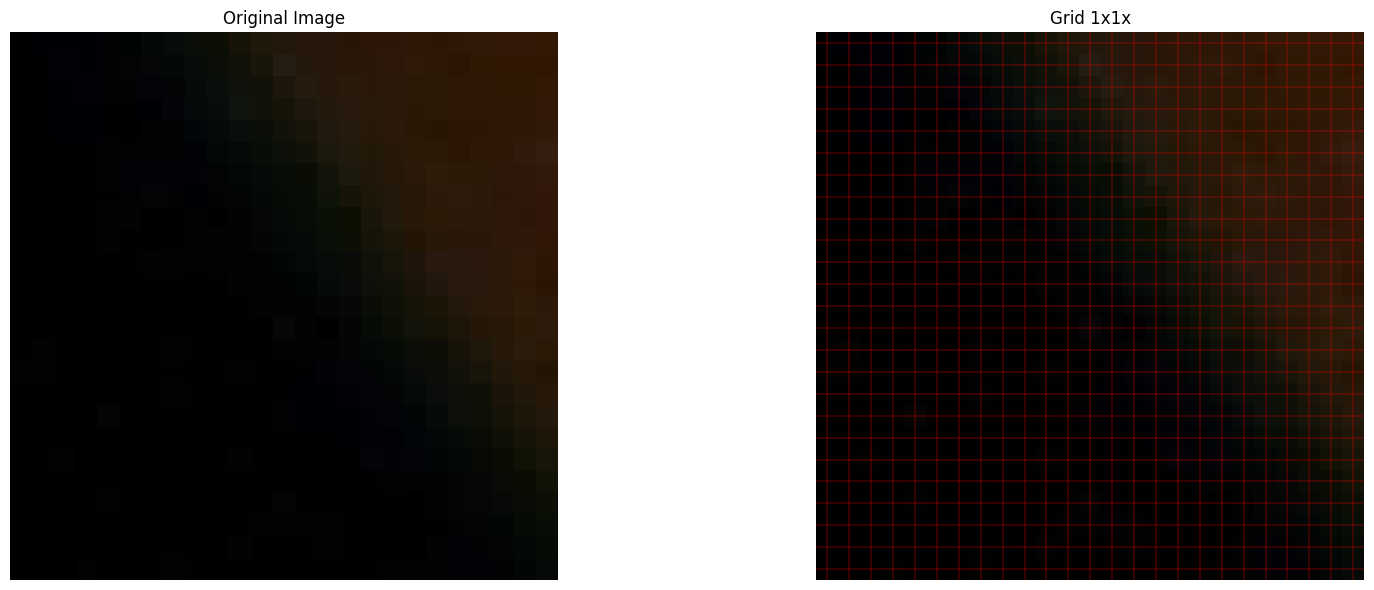

In [26]:
plot_patch_with_matplotlib_grid(rgb_patches, random_index)


### CLAHE

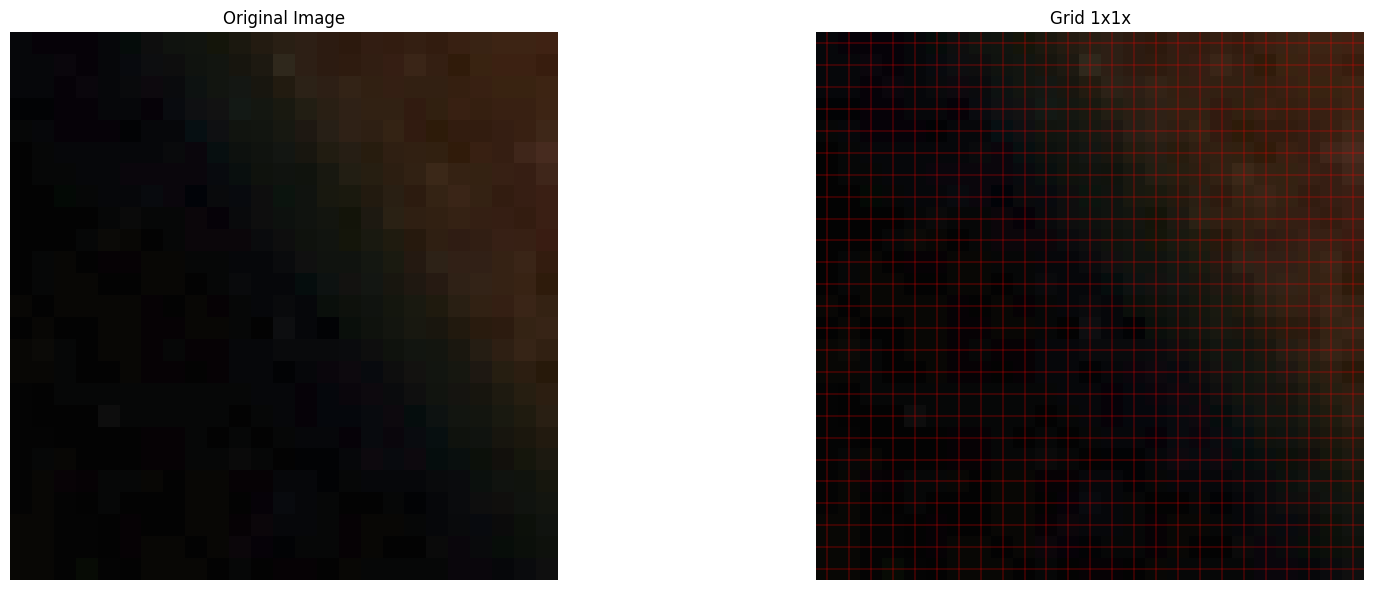

In [27]:
plot_patch_with_matplotlib_grid(clahe_patches, random_index)


### Green Channel

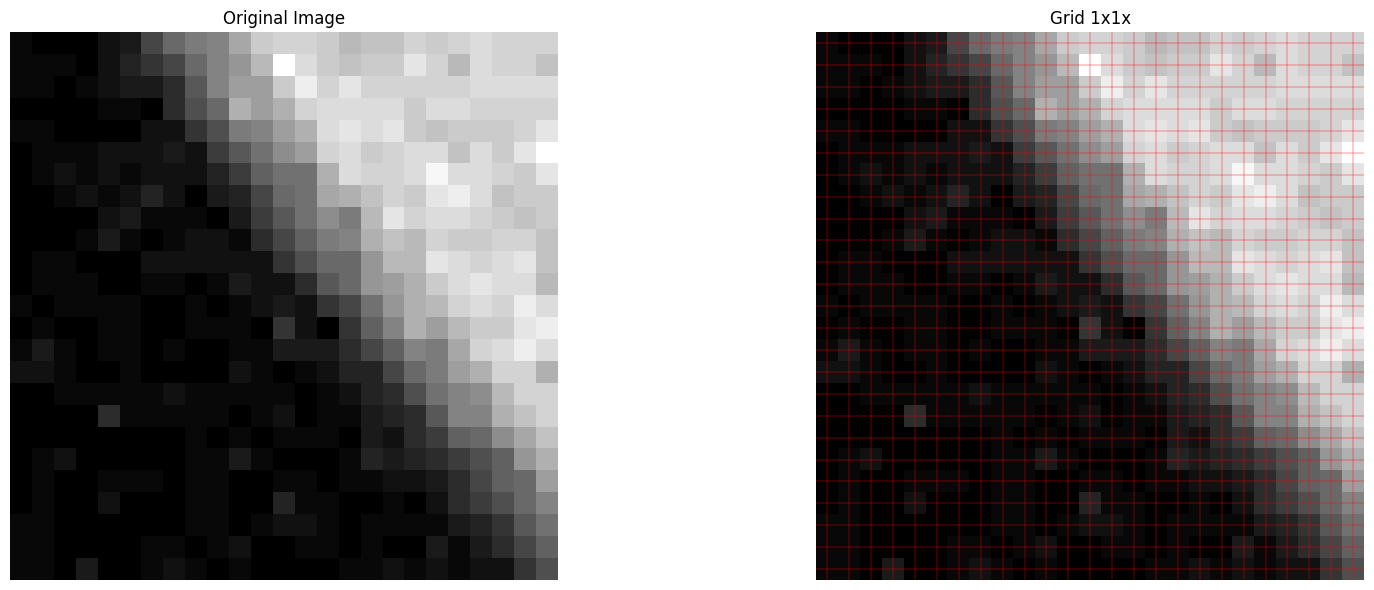

In [28]:
plot_patch_with_matplotlib_grid(green_channel_patches, random_index, cmap='gray')


### Green Channel + CLAHE

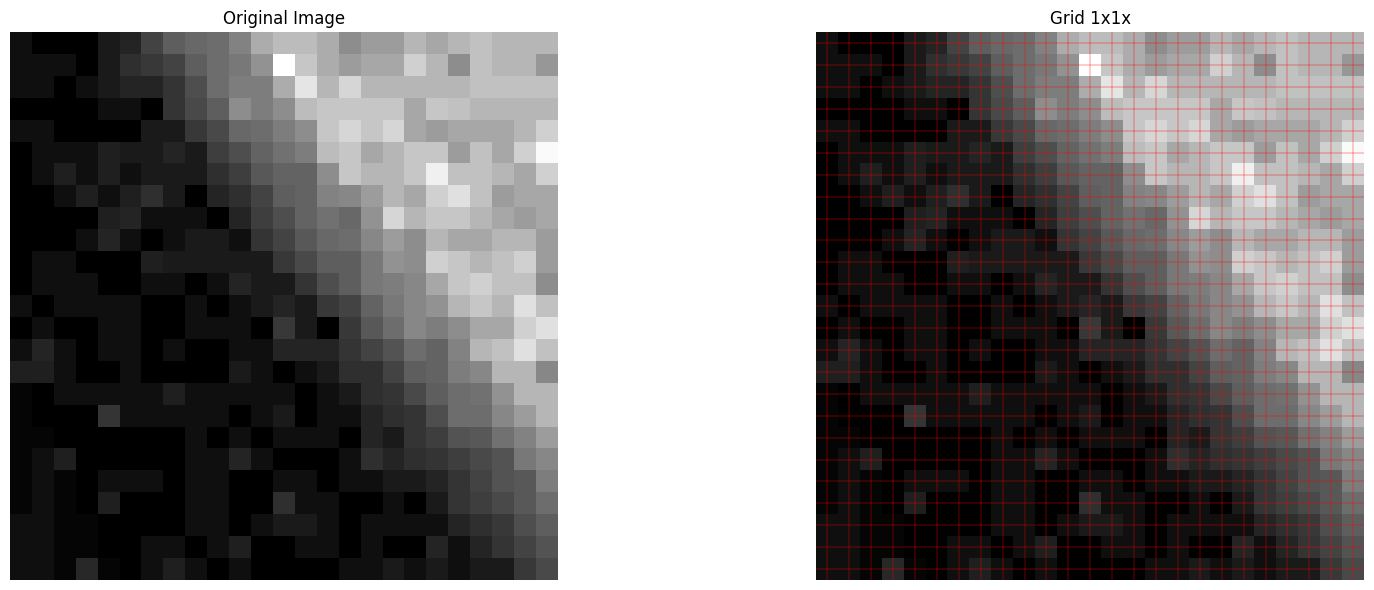

In [29]:
plot_patch_with_matplotlib_grid(green_channel_clahe_patches, random_index, cmap='gray')


## Reconstructing the Retina

This took some intense debugging, but I finally managed to reconstruct a part of the retina from the patches. The idea is to take all patches, and put them back together in a grid-like fashion. If you grab the first `n` patches, it'doesn't represent a region...

This isn't really useful, but it was a fun to see how the patches fit together.

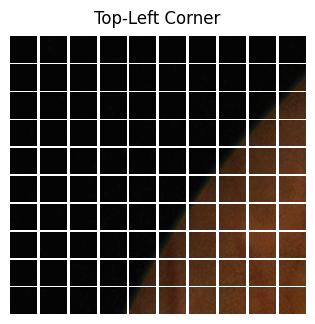

In [30]:
patches_per_row = 60  # for 1500 / 25 = 60 patches per row
row_start = 0
col_start = 0
block_size = 10

subset = []
for r in range(block_size):
    for c in range(block_size):
        index = (row_start + r) * patches_per_row + (col_start + c)
        subset.append(clahe_patches["patch"][index])

plot_patch_block(subset, n_rows=10, n_cols=10, cmap='gray', title="Top-Left Corner")


## Classifying the Patches

> Note: The `XML` files have already been parsed and stored as a pandas data frame (`lesions_pd_frame`). For more info see one of the cells above (towards the beginning).

In [31]:
lesions_pd_frame.head()


image_path            image_id  \
0  images/diaretdb1_image002.png  diaretdb1_image002   
1  images/diaretdb1_image002.png  diaretdb1_image002   
2  images/diaretdb1_image002.png  diaretdb1_image002   
3  images/diaretdb1_image002.png  diaretdb1_image002   
4  images/diaretdb1_image002.png  diaretdb1_image002   

                          xml_file          type  lesion_id       x      y  \
0  diaretdb1_image002_01_plain.xml  Haemorrhages          0   570.0  805.0   
1  diaretdb1_image002_01_plain.xml  Haemorrhages          1   669.0  685.0   
2  diaretdb1_image002_01_plain.xml  Haemorrhages          2   811.0  733.0   
3  diaretdb1_image002_01_plain.xml  Haemorrhages          3   895.0  700.0   
4  diaretdb1_image002_01_plain.xml  Haemorrhages          4  1054.0  716.0   

   radius  radius_x  radius_y  angle polygon_points   region_type  
0    16.0       NaN       NaN    NaN             []  circleregion  
1    20.0       NaN       NaN    NaN             []  circleregion  
2    48.0       NaN       NaN    NaN             []  circleregion  
3     5.0       NaN       NaN    NaN             []  circleregion  
4     5.0       NaN       NaN    NaN             []  circleregion

In [32]:
labeled_df_green_clahe = label_patches_from_lesions(green_channel_clahe_patches, lesions_pd_frame)


### Initial Results

As I discussed above, this is the result of "combining the labels". Here, the label field (`label`) is a tuple instead of a single string. If there is no lesion, the label field is set to `healthy`.

I don't hate this approach, because it opens the door to multiple ways of removing overlapping lesions. 

#### Ways to Remove Overlapping Lesions
0. **Deduplicate Labels by Type**<br>
  I don't think this is really viable here, since it's the "lazy" type of filtering. If a patch contains multiple lesions of the same type, reduce them to a single label instance. This doesn’t resolve overlaps between different types, but avoids redundant class tagging. I plan on starting with this to exclude obvious duplicates...easing my workload later.

1. **Majority Agreement Voting**<br>
  If a patch contains multiple lesions of different types, use the most common type as the label. I got this from StackOverflow...sounds a little janky, but I guess could work.

2. **Priority XML**<br>
  Use a single XML file as the "source of truth". Again, this is kinda janky, because we can't say for sure which file "is more correct". This was my 2AM idea...

3. **DBSCAN**<br>
  Tried this last week, but it's a little risky because it can merge lesions that are actually separate. It’s a clustering algorithm...based on density...

4. **Classic Segmentation (From the Meeting on Jun 30th)** <br> 
  Compare the number of pixels of each and grab the one with a higher pixel count. The only issue I see with this is if the lesions spreads across 4 patches, and is of size 4 pixels. If those 4 patches contain a lesion that is of size > 1 pixel, semantic segmentation will not work. As of right now I think this is an edge case with a low probability of happening, but can never be too sure.

5. **Proximity Based Matching** <br>
  Compare the center of each patch and grab the one with the closest center to the lesion. This is a bit more robust, but can still fail if the lesion is large and overlaps with multiple patches.

6. **Train a model (Time + Resource consumption is high...optional for now...)**<br>
  Train a model to classify the patches based on the lesion type. This is the most robust solution, but requires a lot of data and computational resources.

I'm starting with **Deduplication by Type** & **Classic Segmentation** for now, and will see how it goes. If I run into issues, I'll switch to **Proximity Based Matching**. If that doesn't work, then...idk...training a model is the last resort.

In [33]:
labeled_df_green_clahe["label"].value_counts()


label
healthy                           2725
Hard_exudates                       12
(Haemorrhages, Red_small_dots)       8
Red_small_dots                       7
Haemorrhages                         6
Disc                                 2
Name: count, dtype: int64

I think classic deduplication actually works better than expected here. I need to do some thorough testing to see how it performs, but I think it will work well enough for now. If I run into issues, I can always pivot to something else...

## Finding the Patches with Multiple Labels

> Note: After removing the overlapping lesions of the same type.

A tuple of size 4, where all elements are the same, is reduced to a single element. In a more "mathy" way...if a tuple contains an arbitrary number `n` of elements `e`, they get reduced to a single element `e`. If not, the tuple is kept as is.

```python
(e, e, e, e) -> e
```

**Concrete Example:**
```python
(Haemorrhages, Haemorrhages, Haemorrhages, Haemorrhages) -> Haemorrhages
```

In [34]:
multiple_labels = labeled_df_green_clahe[labeled_df_green_clahe["overlap_flag"] == True]
multiple_labels.head(n=len(multiple_labels))


source_img  patch_no  \
744   diaretdb1_image002.png       745   
1416  diaretdb1_image002.png      1417   
1646  diaretdb1_image002.png      1647   
1722  diaretdb1_image002.png      1723   
1771  diaretdb1_image002.png      1772   
1772  diaretdb1_image002.png      1773   
1773  diaretdb1_image002.png      1774   
1839  diaretdb1_image002.png      1840   

                                                  patch       center  \
744   [[85, 82, 85, 85, 85, 90, 87, 87, 90, 90, 87, ...   (612, 312)   
1416  [[58, 58, 58, 66, 64, 64, 69, 63, 63, 60, 58, ...   (912, 587)   
1646  [[79, 73, 65, 71, 73, 68, 62, 68, 65, 62, 65, ...   (662, 687)   
1722  [[78, 83, 81, 78, 78, 78, 71, 68, 71, 68, 66, ...  (1062, 712)   
1771  [[69, 66, 66, 69, 66, 69, 69, 66, 72, 75, 72, ...   (787, 737)   
1772  [[64, 70, 78, 78, 78, 81, 78, 76, 76, 73, 70, ...   (812, 737)   
1773  [[70, 73, 67, 73, 79, 87, 81, 73, 79, 79, 79, ...   (837, 737)   
1839  [[82, 85, 79, 76, 76, 73, 68, 79, 87, 76, 76, ...   (987, 762)   

                                            coordinates  \
744   {'top_left': (600, 300), 'top_right': (624, 30...   
1416  {'top_left': (900, 575), 'top_right': (924, 57...   
1646  {'top_left': (650, 675), 'top_right': (674, 67...   
1722  {'top_left': (1050, 700), 'top_right': (1074, ...   
1771  {'top_left': (775, 725), 'top_right': (799, 72...   
1772  {'top_left': (800, 725), 'top_right': (824, 72...   
1773  {'top_left': (825, 725), 'top_right': (849, 72...   
1839  {'top_left': (975, 750), 'top_right': (999, 75...   

                               label  overlap_flag  lesion_id  
744   (Haemorrhages, Red_small_dots)          True        744  
1416  (Haemorrhages, Red_small_dots)          True       1416  
1646  (Haemorrhages, Red_small_dots)          True       1646  
1722  (Haemorrhages, Red_small_dots)          True       1722  
1771  (Haemorrhages, Red_small_dots)          True       1771  
1772  (Haemorrhages, Red_small_dots)          True       1772  
1773  (Haemorrhages, Red_small_dots)          True       1773  
1839  (Haemorrhages, Red_small_dots)          True       1839

### Visualizing the Patches with Multiple Labels

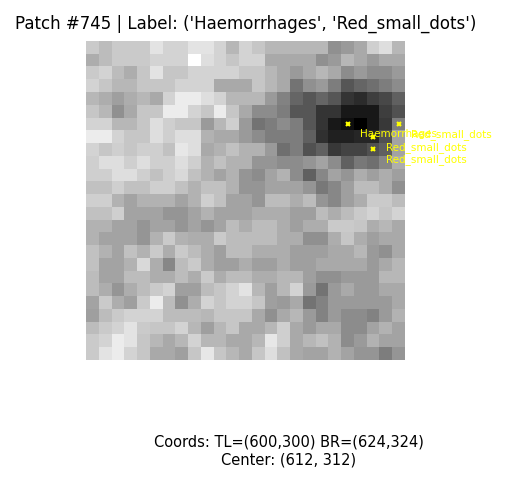

In [35]:
patch_744 = labeled_df_green_clahe.iloc[744]
plot_patch_with_lesions(patch_744, lesions_pd_frame)


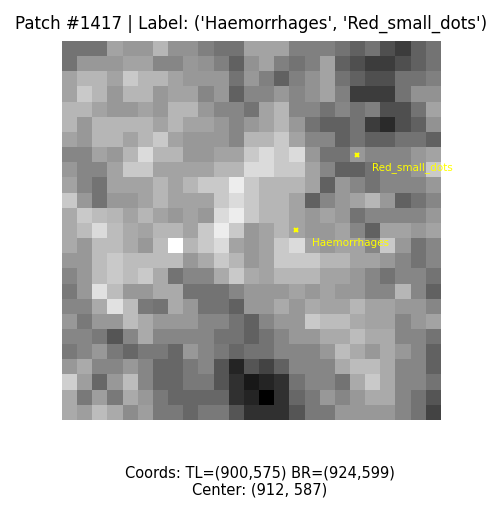

In [36]:
patch_1416 = labeled_df_green_clahe.iloc[1416]
plot_patch_with_lesions(patch_1416, lesions_pd_frame)


### Visualizing the Area of Patches with Multiple Labels (Different Types/Class)

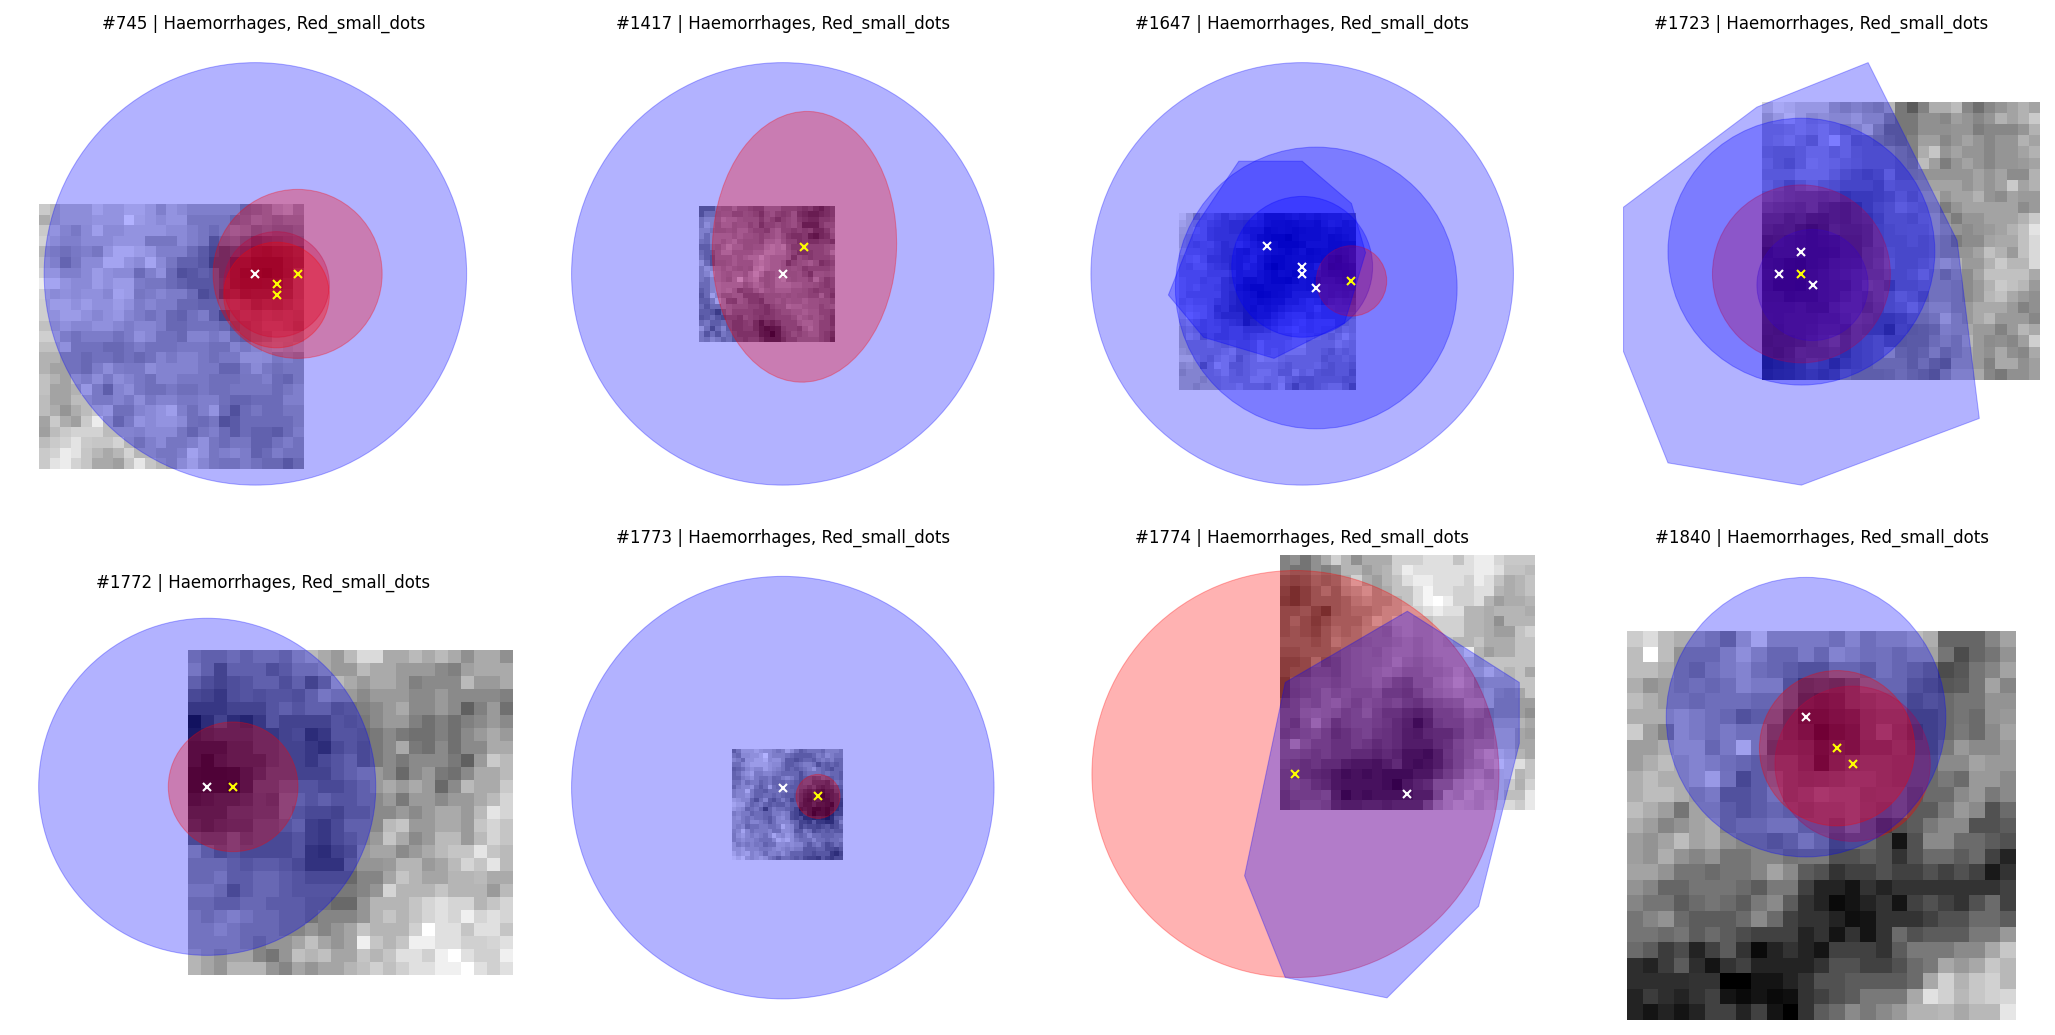

In [37]:
overlapping_patches = labeled_df_green_clahe[
    labeled_df_green_clahe['overlap_flag'] & labeled_df_green_clahe['label'].apply(lambda x: isinstance(x, tuple))
]

visualize_lesion_regions_subplots(overlapping_patches, lesions_pd_frame)


#### **Note: [`Circle`] Colors**
- **Blue** — `haemorrhages`  
- **Red** — `red_small_dots`  
- **Green** — `hard_exudates`  
- **Orange** — `soft_exudates`  
- **Purple** — `disc`  
- **Cyan** — `irma`  
- **Magenta** — `neovascularisation`  
- **Yellow** — `fundus_area`  

---

#### **Note: [`Tick`] Colors**
- **White** — `haemorrhages`  
- **Yellow** — `red_small_dots`  
- **Black** — `hard_exudates`  
- **Blue** — `soft_exudates`  
- **White** — `disc`  
- **Black** — `irma`  
- **Yellow** — `neovascularisation`  
- **Black** — `fundus_area`  

Believe it or not, it's really hard to think of colors. If some clash at some point, we can always go back and change them. In the end they are probably going to be in a config file, so it's not really a huge issue right now.

Anyways, this looks decent in my opinion. I think it's a great representation of how to resolve overlapping lesions. My current approach is to go with "Whichever lesion has the bigger area, grab it and make it the label"...

### Removing the Patches with Multiple Labels (Different Types/Class)

In [38]:
relabeled_df = relabel_patches_by_area(labeled_df_green_clahe, lesions_pd_frame)
relabeled_df.head()


source_img  patch_no  \
0  diaretdb1_image002.png         1   
1  diaretdb1_image002.png         2   
2  diaretdb1_image002.png         3   
3  diaretdb1_image002.png         4   
4  diaretdb1_image002.png         5   

                                               patch     center  \
0  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...   (12, 12)   
1  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3,...   (37, 12)   
2  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6,...   (62, 12)   
3  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...   (87, 12)   
4  [[3, 3, 3, 3, 3, 6, 6, 6, 3, 3, 3, 6, 3, 3, 3,...  (112, 12)   

                                         coordinates    label  overlap_flag  \
0  {'top_left': (0, 0), 'top_right': (24, 0), 'bo...  healthy         False   
1  {'top_left': (25, 0), 'top_right': (49, 0), 'b...  healthy         False   
2  {'top_left': (50, 0), 'top_right': (74, 0), 'b...  healthy         False   
3  {'top_left': (75, 0), 'top_right': (99, 0), 'b...  healthy         False   
4  {'top_left': (100, 0), 'top_right': (124, 0), ...  healthy         False   

   lesion_id relabel_label area_map relabel  
0          0       healthy       {}      []  
1          1       healthy       {}      []  
2          2       healthy       {}      []  
3          3       healthy       {}      []  
4          4       healthy       {}      []

> **Note**: This adds a new field called `relabel_label` indicating the new label using the area comparison. And a dictionary `relabel` with necessary data for dataviz.

## Results

From earlier we know that the following patches had duplicate tags:

```python
# @see above
[744, 1416, 1646, 1722, 1771, 1772, 1773, 1839]
```

Let's compare the results. `labeled_df_green_clahe` is our original data frame of labeled patches. `relabeled_df` is our new data frame.


In [44]:
target_patch_nos = [745, 1417, 1647, 1723, 1772, 1773, 1774, 1840]

relabeled_df[relabeled_df['patch_no'].isin(target_patch_nos)].tail(n=2)


source_img  patch_no  \
1773  diaretdb1_image002.png      1774   
1839  diaretdb1_image002.png      1840   

                                                  patch      center  \
1773  [[70, 73, 67, 73, 79, 87, 81, 73, 79, 79, 79, ...  (837, 737)   
1839  [[82, 85, 79, 76, 76, 73, 68, 79, 87, 76, 76, ...  (987, 762)   

                                            coordinates  \
1773  {'top_left': (825, 725), 'top_right': (849, 72...   
1839  {'top_left': (975, 750), 'top_right': (999, 75...   

                               label  overlap_flag  lesion_id   relabel_label  \
1773  (Haemorrhages, Red_small_dots)          True       1773  red_small_dots   
1839  (Haemorrhages, Red_small_dots)          True       1839    haemorrhages   

                                   area_map  \
1773  {'red_small_dots': 396.3555978681395}   
1839   {'haemorrhages': 212.08168809734084}   

                                                relabel  
1773  [{'image_path': 'images/diaretdb1_image002.png...  
1839  [{'image_path': 'images/diaretdb1_image002.png...

## Plotting the new Re-Labeled Patches

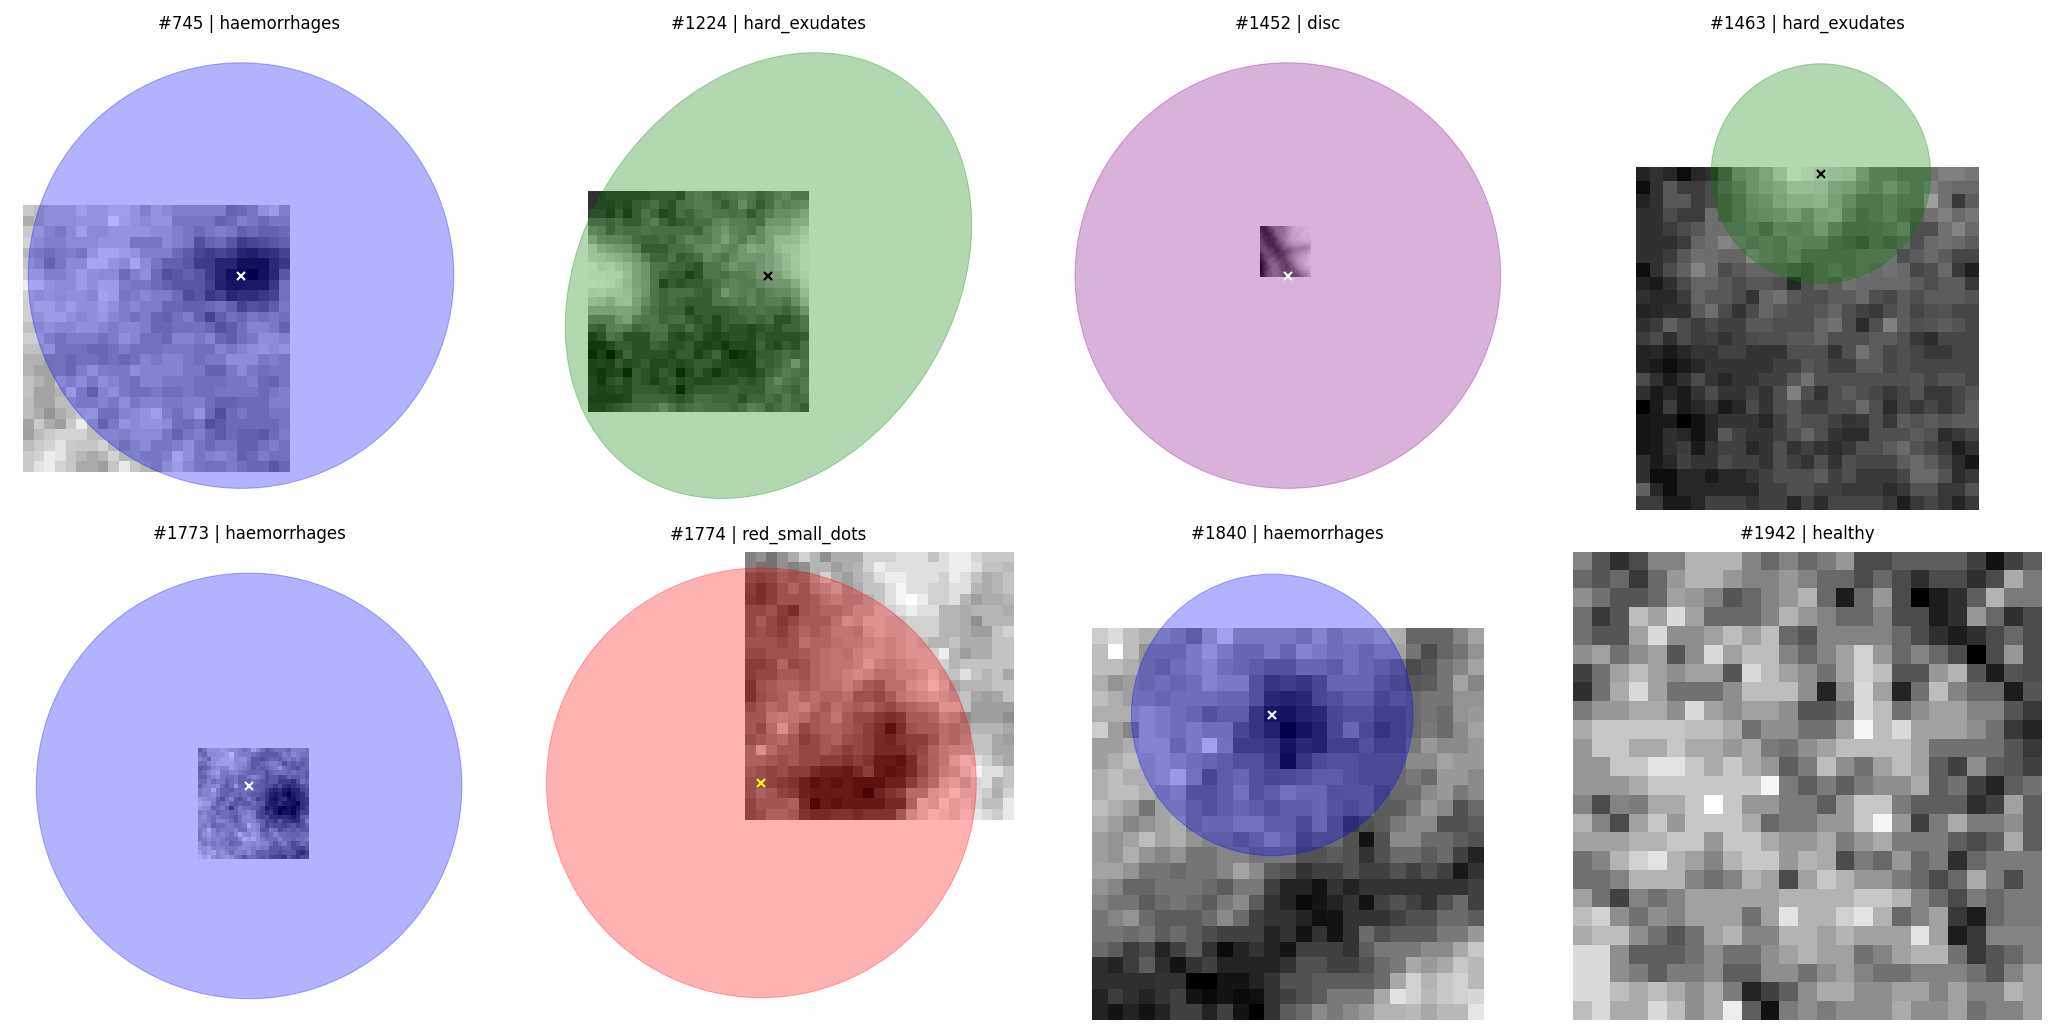

In [60]:
def extract_lesions_from_relabeled_df(df):
    all_lesions = []
    for _, row in df.iterrows():
        if isinstance(row.get("relabel"), list):
            all_lesions.extend(row["relabel"])
    return pd.DataFrame(all_lesions)

patch_nos_to_plot = [745, 1223, 1452, 1942, 1463, 1773, 1774, 1840]
selected_patches = relabeled_df[relabeled_df['patch_no'].isin(patch_nos_to_plot)].copy()
filtered_lesions_df = extract_lesions_from_relabeled_df(selected_patches)

visualize_lesion_regions_subplots(selected_patches, filtered_lesions_df, plotting_relabeled=True)


In [52]:
non_healthy_df = relabeled_df[relabeled_df['relabel_label'] != 'healthy']

non_healthy_df.head(n=len(non_healthy_df))


source_img  patch_no  \
490   diaretdb1_image002.png       491   
556   diaretdb1_image002.png       557   
744   diaretdb1_image002.png       745   
757   diaretdb1_image002.png       758   
817   diaretdb1_image002.png       818   
1166  diaretdb1_image002.png      1167   
1223  diaretdb1_image002.png      1224   
1235  diaretdb1_image002.png      1236   
1246  diaretdb1_image002.png      1247   
1281  diaretdb1_image002.png      1282   
1283  diaretdb1_image002.png      1284   
1284  diaretdb1_image002.png      1285   
1346  diaretdb1_image002.png      1347   
1356  diaretdb1_image002.png      1357   
1406  diaretdb1_image002.png      1407   
1407  diaretdb1_image002.png      1408   
1416  diaretdb1_image002.png      1417   
1451  diaretdb1_image002.png      1452   
1462  diaretdb1_image002.png      1463   
1511  diaretdb1_image002.png      1512   
1527  diaretdb1_image002.png      1528   
1534  diaretdb1_image002.png      1535   
1646  diaretdb1_image002.png      1647   
1655  diaretdb1_image002.png      1656   
1711  diaretdb1_image002.png      1712   
1713  diaretdb1_image002.png      1714   
1715  diaretdb1_image002.png      1716   
1722  diaretdb1_image002.png      1723   
1771  diaretdb1_image002.png      1772   
1772  diaretdb1_image002.png      1773   
1773  diaretdb1_image002.png      1774   
1839  diaretdb1_image002.png      1840   
1900  diaretdb1_image002.png      1901   
1942  diaretdb1_image002.png      1943   
2504  diaretdb1_image002.png      2505   

                                                  patch        center  \
490   [[56, 54, 54, 48, 54, 59, 59, 53, 53, 51, 53, ...    (262, 212)   
556   [[68, 74, 74, 71, 68, 74, 78, 74, 68, 71, 74, ...    (412, 237)   
744   [[85, 82, 85, 85, 85, 90, 87, 87, 90, 90, 87, ...    (612, 312)   
757   [[67, 62, 62, 62, 59, 62, 64, 59, 59, 65, 71, ...    (937, 312)   
817   [[82, 85, 85, 82, 87, 85, 87, 82, 87, 90, 82, ...    (937, 337)   
1166  [[68, 68, 73, 70, 73, 73, 65, 68, 70, 68, 76, ...    (662, 487)   
1223  [[69, 69, 72, 72, 72, 72, 72, 75, 75, 75, 72, ...    (587, 512)   
1235  [[86, 92, 97, 98, 101, 105, 108, 106, 105, 104...    (887, 512)   
1246  [[61, 55, 56, 58, 61, 62, 62, 62, 56, 59, 56, ...   (1162, 512)   
1281  [[82, 87, 85, 85, 87, 87, 92, 101, 106, 109, 1...    (537, 537)   
1283  [[72, 69, 78, 86, 83, 86, 83, 89, 83, 78, 81, ...    (587, 537)   
1284  [[84, 87, 93, 101, 107, 111, 111, 115, 114, 10...    (612, 537)   
1346  [[65, 65, 62, 62, 62, 65, 65, 59, 62, 68, 62, ...    (662, 562)   
1356  [[74, 74, 77, 74, 79, 85, 79, 79, 79, 74, 68, ...    (912, 562)   
1406  [[75, 69, 67, 67, 72, 69, 70, 73, 75, 73, 67, ...    (662, 587)   
1407  [[64, 58, 61, 58, 61, 58, 64, 59, 59, 62, 62, ...    (687, 587)   
1416  [[58, 58, 58, 66, 64, 64, 69, 63, 63, 60, 58, ...    (912, 587)   
1451  [[86, 84, 82, 93, 105, 116, 126, 126, 131, 127...    (287, 612)   
1462  [[66, 69, 67, 61, 67, 69, 78, 90, 93, 99, 107,...    (562, 612)   
1511  [[76, 86, 95, 106, 113, 116, 122, 124, 129, 12...    (287, 637)   
1527  [[65, 62, 65, 65, 65, 65, 62, 62, 62, 68, 71, ...    (687, 637)   
1534  [[64, 67, 69, 72, 75, 69, 67, 67, 69, 61, 61, ...    (862, 637)   
1646  [[79, 73, 65, 71, 73, 68, 62, 68, 65, 62, 65, ...    (662, 687)   
1655  [[81, 81, 78, 81, 83, 83, 86, 86, 83, 89, 89, ...    (887, 687)   
1711  [[87, 73, 71, 74, 74, 77, 79, 82, 82, 82, 82, ...    (787, 712)   
1713  [[66, 66, 68, 74, 74, 77, 74, 72, 72, 72, 75, ...    (837, 712)   
1715  [[75, 78, 78, 75, 72, 75, 72, 69, 63, 72, 80, ...    (887, 712)   
1722  [[78, 83, 81, 78, 78, 78, 71, 68, 71, 68, 66, ...   (1062, 712)   
1771  [[69, 66, 66, 69, 66, 69, 69, 66, 72, 75, 72, ...    (787, 737)   
1772  [[64, 70, 78, 78, 78, 81, 78, 76, 76, 73, 70, ...    (812, 737)   
1773  [[70, 73, 67, 73, 79, 87, 81, 73, 79, 79, 79, ...    (837, 737)   
1839  [[82, 85, 79, 76, 76, 73, 68, 79, 87, 76, 76, ...    (987, 762)   
1900  [[81, 78, 78, 81, 87, 84, 84, 84, 84, 84, 78, ...   (1012, 787)   
1942  [[79, 74, 76, 79,

In [57]:
# Find one polygon shape
polygon_row = next(
    (row for _, row in non_healthy_df.iterrows()
     if any(lesion['region_type'] == 'polygonregion' for lesion in row['relabel'])),
    None
)

# Find one ellipse shape
ellipse_row = next(
    (row for _, row in non_healthy_df.iterrows()
     if any(lesion['region_type'] == 'ellipseregion' for lesion in row['relabel'])),
    None
)

# Optional: Combine into a new DataFrame
subset_df = pd.DataFrame([polygon_row, ellipse_row]) if polygon_row is not None and ellipse_row is not None else pd.DataFrame()

subset_df.head()


source_img  patch_no  \
1246  diaretdb1_image002.png      1247   
1223  diaretdb1_image002.png      1224   

                                                  patch       center  \
1246  [[61, 55, 56, 58, 61, 62, 62, 62, 56, 59, 56, ...  (1162, 512)   
1223  [[69, 69, 72, 72, 72, 72, 72, 75, 75, 75, 72, ...   (587, 512)   

                                            coordinates          label  \
1246  {'top_left': (1150, 500), 'top_right': (1174, ...   Haemorrhages   
1223  {'top_left': (575, 500), 'top_right': (599, 50...  Hard_exudates   

      overlap_flag  lesion_id  relabel_label  \
1246         False       1246   haemorrhages   
1223         False       1223  hard_exudates   

                                  area_map  \
1246  {'haemorrhages': 1925.7874264091638}   
1223   {'hard_exudates': 575.150763081929}   

                                                relabel  
1246  [{'image_path': 'images/diaretdb1_image002.png...  
1223  [{'image_path': 'images/diaretdb1_image002.png...